In [22]:
""" EDA
    auther:  ryoma yokoyama
    created: 2025.05.08 19:58:37
"""
import os
import sys
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib_fontja
import numpy as np
import polars as pl
import seaborn as sns
import tqdm
from hydra import compose, initialize
from omegaconf import OmegaConf

from src.seed import seed_everything

with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config.yaml")
    cfg.exp_number = Path().resolve().name
print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)

warnings.filterwarnings("ignore")


exp_number: '000'
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/000
seed: 42
n_splits: 5
target: SalePrice



## このコンペについて
目的変数（予測対象）： SalePrice  
評価指標： 予測価格の対数と実際の販売価格の対数の間の RMSE (Root-Mean-Squared-Error) です。対数を取ることで、高額な物件と低額な物件の予測誤差が評価に平等に影響するようになっています。

データ：
* train.csv: モデルの学習に使用するデータ（販売価格SalePriceを含む）
* test.csv: 販売価格を予測する対象のデータ（SalePriceは含まない）
* data_description.txt: 各特徴量の詳細な説明
* sample_submission.csv: 提出ファイルの形式例

### データの説明

- `Id`: **ID** - 各物件の識別子。
- `MSSubClass`: **建物のクラス** - 販売に関わる住居の種類を識別します。
  - 例: `20` (1階建て 1946年以降 全スタイル)、`60` (2階建て 1946年以降)など。
- `MSZoning`: **一般的なゾーニング分類** - 販売物件の地域区分。
  - 例: `A` (農業)、`RL` (低密度住宅)、`RM` (中密度住宅)など。
- `LotFrontage`: **道路に面している長さ** - 物件に接続する道路の直線フィート。欠損値は近隣の物件の中央値などで補完することが多いです。
- `LotArea`: **敷地面積** - 平方フィート単位。
- `Street`: **道路アクセスの種類**。
  - `Grvl`: 砂利道
  - `Pave`: 舗装路
- `Alley`: **路地アクセスの種類**。
  - `Grvl`: 砂利
  - `Pave`: 舗装
  - `NA`: 路地アクセスなし
- `LotShape`: **敷地の一般的な形状**。
  - `Reg`: 整形
  - `IR1`: やや不整形
  - `IR2`: 中程度に不整形
  - `IR3`: 不整形
- `LandContour`: **敷地の平坦度**。
  - `Lvl`: ほぼ平坦/水平
  - `Bnk`: 銀行 - 道路から建物までの急な高低差
  - `HLS`: 丘陵地 - 横方向の著しい傾斜
  - `Low`: 低地、くぼ地
- `Utilities`: **利用可能なユーティリティの種類**。
  - `AllPub`: 全ての公共設備 (電気、ガス、水道、下水)
  - `NoSewr`: 電気、ガス、水道 (浄化槽)
  - `NoSeWa`: 電気とガスのみ
  - `ELO`: 電気のみ
- `LotConfig`: **敷地区画の配置**。
  - `Inside`: 内側区画
  - `Corner`: 角地区画
  - `CulDSac`: 袋小路
  - `FR2`: 敷地の2辺が道路に面している
  - `FR3`: 敷地の3辺が道路に面している
- `LandSlope`: **敷地の傾斜**。
  - `Gtl`: 緩やかな傾斜
  - `Mod`: 中程度の傾斜
  - `Sev`: 急な傾斜
- `Neighborhood`: **エイムズ市内の物理的な場所（近隣地域）**。
  - (例: `CollgCr` (College Creek), `OldTown` (Old Town), `Edwards` (Edwards))
- `Condition1`: **近接状況1** - 主要道路や鉄道などへの近さ。
  - `Artery`: 幹線道路に隣接
  - `Feedr`: 補助幹線道路に隣接
  - `Norm`: 通常
  - `RRNn`: 南北鉄道から200フィート以内
  - `RRAn`: 南北鉄道に隣接
  - `PosN`: 公園、緑地帯などの好ましい施設に近い
  - `PosA`: 好ましい施設に隣接
  - `RRNe`: 東西鉄道から200フィート以内
  - `RRAe`: 東西鉄道に隣接
- `Condition2`: **近接状況2** - （複数の条件が存在する場合）。上記`Condition1`と同様のカテゴリ。
- `BldgType`: **住居の種類**。
  - `1Fam`: 一戸建て
  - `2FmCon`: 二世帯住宅（元は一戸建て）
  - `Duplx`: デュープレックス（二戸建て）
  - `TwnhsE`: タウンハウス（端ユニット）
  - `TwnhsI`: タウンハウス（中間ユニット）
- `HouseStyle`: **住居のスタイル**。
  - `1Story`: 1階建て
  - `1.5Fin`: 1.5階建て（2階部分仕上げ済み）
  - `1.5Unf`: 1.5階建て（2階部分未仕上げ）
  - `2Story`: 2階建て
  - `2.5Fin`: 2.5階建て（2階部分仕上げ済み）
  - `2.5Unf`: 2.5階建て（2階部分未仕上げ）
  - `SFoyer`: スプリットホワイエ
  - `SLvl`: スプリットレベル
- `OverallQual`: **全体的な材質と仕上げの品質** - 1から10のスケール。
  - `10`: 最高
  - `1`: 最低
- `OverallCond`: **全体的な状態評価** - 1から10のスケール。
  - `10`: 最高
  - `1`: 最低
- `YearBuilt`: **建築年** - 元の建設日。
- `YearRemodAdd`: **改築年** - 改築日（改築や増築がない場合は建築年と同じ）。
- `RoofStyle`: **屋根のタイプ**。
  - `Flat`: フラット
  - `Gable`: 切妻
  - `Gambrel`: ギャンブレル（腰折れ屋根）
  - `Hip`: 寄棟
  - `Mansard`: マンサード
  - `Shed`: 片流れ
- `RoofMatl`: **屋根の材質**。
  - `ClyTile`: 粘土またはタイル
  - `CompShg`: 標準（コンポジット）シングル
  - `Membran`: 膜防水
  - `Metal`: 金属
  - `Roll`: ロール
  - `Tar&Grv`: 砂利とタール
  - `WdShake`: ウッドシェイク
  - `WdShngl`: ウッドシングル
- `Exterior1st`: **家の外装材（主）**。
  - (例: `VinylSd` (ビニールサイディング), `MetalSd` (金属サイディング), `Wd Sdng` (木製サイディング))
- `Exterior2nd`: **家の外装材（副）** - （複数の素材が使われている場合）。上記`Exterior1st`と同様のカテゴリ。
- `MasVnrType`: **石積みベニヤの種類**。
  - `BrkCmn`: 一般的なレンガ
  - `BrkFace`: 化粧レンガ
  - `CBlock`: シンダーブロック
  - `None`: なし
  - `Stone`: 石
- `MasVnrArea`: **石積みベニヤの面積** - 平方フィート単位。
- `ExterQual`: **外装材の品質**。
  - `Ex`: 優秀
  - `Gd`: 良い
  - `TA`: 平均/標準
  - `Fa`: 普通
  - `Po`: 劣る
- `ExterCond`: **外装材の現在の状態**。上記`ExterQual`と同様のカテゴリ。
- `Foundation`: **基礎の種類**。
  - `BrkTil`: レンガとタイル
  - `CBlock`: シンダーブロック
  - `PConc`: 現場打ちコンクリート
  - `Slab`: スラブ
  - `Stone`: 石
  - `Wood`: 木
- `BsmtQual`: **地下室の高さの評価**。
  - `Ex`: 優秀 (100インチ以上)
  - `Gd`: 良い (90-99インチ)
  - `TA`: 標準 (80-89インチ)
  - `Fa`: 普通 (70-79インチ)
  - `Po`: 劣る (70インチ未満)
  - `NA`: 地下室なし
- `BsmtCond`: **地下室の全体的な状態の評価**。
  - `Ex`: 優秀
  - `Gd`: 良い
  - `TA`: 標準 - わずかな湿気は許容
  - `Fa`: 普通 - 湿気や多少のひび割れ/沈下あり
  - `Po`: 劣る - 深刻なひび割れ、沈下、または湿気あり
  - `NA`: 地下室なし
- `BsmtExposure`: **地下室の壁の露出度** - ウォークアウトまたはガーデンレベルの壁を指す。
  - `Gd`: 良好な露出
  - `Av`: 平均的な露出 (スプリットレベルやホワイエは通常平均以上)
  - `Mn`: 最小限の露出
  - `No`: 露出なし
  - `NA`: 地下室なし
- `BsmtFinType1`: **地下室の仕上げ済みエリアの評価（タイプ1）**。
  - `GLQ`: 良質な居住空間
  - `ALQ`: 平均的な居住空間
  - `BLQ`: 平均以下の居住空間
  - `Rec`: 平均的な娯楽室
  - `LwQ`: 低品質
  - `Unf`: 未仕上げ
  - `NA`: 地下室なし
- `BsmtFinSF1`: **タイプ1仕上げ済み地下室の面積** - 平方フィート単位。
- `BsmtFinType2`: **地下室の仕上げ済みエリアの評価（タイプ2）** - （複数のタイプがある場合）。上記`BsmtFinType1`と同様のカテゴリ。
- `BsmtFinSF2`: **タイプ2仕上げ済み地下室の面積** - 平方フィート単位。
- `BsmtUnfSF`: **未仕上げの地下室の面積** - 平方フィート単位。
- `TotalBsmtSF`: **地下室の総面積** - 平方フィート単位。
- `Heating`: **暖房の種類**。
  - `Floor`: 床暖房炉
  - `GasA`: ガス強制温風炉
  - `GasW`: ガス温水または蒸気暖房
  - `Grav`: 重力式暖房炉
  - `OthW`: ガス以外の温水または蒸気暖房
  - `Wall`: 壁掛け式暖房炉
- `HeatingQC`: **暖房の品質と状態**。上記`ExterQual`と同様のカテゴリ。
- `CentralAir`: **セントラルエアコンの有無**。
  - `N`: なし
  - `Y`: あり
- `Electrical`: **電気系統**。
  - `SBrkr`: 標準的な回路ブレーカーとロメックス配線
  - `FuseA`: 60アンペア以上のヒューズボックスと全ロメックス配線（平均）
  - `FuseF`: 60アンペアヒューズボックスと大部分ロメックス配線（普通）
  - `FuseP`: 60アンペアヒューズボックスと大部分ノブ＆チューブ配線（劣る）
  - `Mix`: 混合
- `1stFlrSF`: **1階の面積** - 平方フィート単位。
- `2ndFlrSF`: **2階の面積** - 平方フィート単位。
- `LowQualFinSF`: **低品質仕上げの面積** - （全フロア合計）平方フィート単位。
- `GrLivArea`: **地上（1階以上）のリビングエリア面積** - 平方フィート単位。
- `BsmtFullBath`: **地下室のフルバスルームの数**。
- `BsmtHalfBath`: **地下室のハーフバスルームの数**。
- `FullBath`: **地上階のフルバスルームの数**。
- `HalfBath`: **地上階のハーフバスルームの数**。
- `Bedroom`: **地上階の寝室数** - （地下室の寝室は含まない）。`BedroomAbvGr`と表記されることも。
- `Kitchen`: **地上階のキッチン数**。`KitchenAbvGr`と表記されることも。
- `KitchenQual`: **キッチンの品質**。上記`ExterQual`と同様のカテゴリ。
- `TotRmsAbvGrd`: **地上階の総部屋数** - （バスルームは含まない）。
- `Functional`: **住宅の機能性評価** - （特に問題がなければTypicalと仮定）。
  - `Typ`: 標準機能
  - `Min1`: 軽微な不具合1
  - `Min2`: 軽微な不具合2
  - `Mod`: 中程度の不具合
  - `Maj1`: 重大な不具合1
  - `Maj2`: 重大な不具合2
  - `Sev`: 深刻な損傷
  - `Sal`: 解体のみ
- `Fireplaces`: **暖炉の数**。
- `FireplaceQu`: **暖炉の品質**。
  - `Ex`: 優秀 - 例外的な石積み暖炉
  - `Gd`: 良い - 主要階の石積み暖炉
  - `TA`: 平均 - 主要リビングエリアのプレハブ式暖炉または地下室の石積み暖炉
  - `Fa`: 普通 - 地下室のプレハブ式暖炉
  - `Po`: 劣る - ベン・フランクリン型ストーブ
  - `NA`: 暖炉なし
- `GarageType`: **ガレージの場所/種類**。
  - `2Types`: 複数のタイプのガレージ
  - `Attchd`: 母屋に接続
  - `Basment`: 地下ガレージ
  - `BuiltIn`: 組み込み式（通常ガレージの上に部屋がある）
  - `CarPort`: カーポート
  - `Detchd`: 母屋から分離
  - `NA`: ガレージなし
- `GarageYrBlt`: **ガレージの建築年**。
- `GarageFinish`: **ガレージの内装仕上げ**。
  - `Fin`: 仕上げ済み
  - `RFn`: 部分仕上げ（Rough Finished）
  - `Unf`: 未仕上げ
  - `NA`: ガレージなし
- `GarageCars`: **ガレージの収容台数**（車）。
- `GarageArea`: **ガレージの面積** - 平方フィート単位。
- `GarageQual`: **ガレージの品質**。上記`ExterQual`と同様のカテゴリ（NAはガレージなし）。
- `GarageCond`: **ガレージの状態**。上記`ExterQual`と同様のカテゴリ（NAはガレージなし）。
- `PavedDrive`: **舗装された私道**。
  - `Y`: 舗装済み
  - `P`: 部分舗装
  - `N`: 未舗装/砂利
- `WoodDeckSF`: **ウッドデッキの面積** - 平方フィート単位。
- `OpenPorchSF`: **オープンポーチの面積** - 平方フィート単位。
- `EnclosedPorch`: **囲まれたポーチの面積** - 平方フィート単位。
- `3SsnPorch`: **スリーシーズンポーチの面積** - 平方フィート単位。
- `ScreenPorch`: **スクリーンポーチの面積** - 平方フィート単位。
- `PoolArea`: **プールの面積** - 平方フィート単位。
- `PoolQC`: **プールの品質**。
  - `Ex`: 優秀
  - `Gd`: 良い
  - `TA`: 平均/標準
  - `Fa`: 普通
  - `NA`: プールなし
- `Fence`: **フェンスの品質**。
  - `GdPrv`: 良好なプライバシー
  - `MnPrv`: 最低限のプライバシー
  - `GdWo`: 良好な木製
  - `MnWw`: 最低限の木製/ワイヤー
  - `NA`: フェンスなし
- `MiscFeature`: **その他の特筆すべき特徴** - （他のカテゴリに含まれないもの）。
  - `Elev`: エレベーター
  - `Gar2`: 2つ目のガレージ（ガレージセクションで記述されていない場合）
  - `Othr`: その他
  - `Shed`: 物置（100平方フィート以上）
  - `TenC`: テニスコート
  - `NA`: なし
- `MiscVal`: **その他の特徴の価値** - ドル単位。
- `MoSold`: **販売月** - (MM)。
- `YrSold`: **販売年** - (YYYY)。
- `SaleType`: **販売の種類**。
  - `WD`: 保証証書 - 通常
  - `CWD`: 保証証書 - 現金
  - `VWD`: 保証証書 - VAローン
  - `New`: 新築販売
  - `COD`: 裁判所執行官証書/遺産
  - `Con`: 契約 - 頭金15%、通常条件
  - `ConLw`: 契約 - 低頭金、低金利
  - `ConLI`: 契約 - 低金利
  - `ConLD`: 契約 - 低頭金
  - `Oth`: その他
- `SaleCondition`: **販売の条件**。
  - `Normal`: 通常の販売
  - `Abnorml`: 通常でない販売 - トレード、差し押さえ、ショートセールなど
  - `AdjLand`: 隣接土地購入
  - `Alloca`: 割り当て - 別々の証書を持つ2つの関連物件（通常、ガレージユニット付きのコンドミニアムなど）
  - `Family`: 家族間の販売
  - `Partial`: 最終査定時に未完成だった住宅（新築住宅に関連）
- `SalePrice`: **販売価格** - ドル単位。このコンペティションで予測するターゲット変数です。 (train.csvにのみ存在)

In [5]:
train_df = pl.read_csv(cfg.data.train_path, infer_schema_length=10_000)

# train_dfから型を取得
train_schema = train_df.schema

# ComputeError: could not parse `NA` as dtype `i64`が出るためnull_valuesを指定
test_df = pl.read_csv(
    cfg.data.test_path,
    schema_overrides=train_schema,
    null_values=["NA"],
)

print("■ train")
display(train_df.head())
print("■ test")
display(test_df.head())

print("■ train")
display(train_df.describe())
print(train_df.dtypes)
print(f"行数: {train_df.shape[0]}, 列数: {train_df.shape[1]}")

print("\n■ test")
display(test_df.describe())
print(test_df.dtypes)
print(f"行数: {test_df.shape[0]}, 列数: {test_df.shape[1]}")


■ train


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,…,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
i64,i64,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,str,str,str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64
1,60,"""RL""","""65""",8450,"""Pave""","""NA""","""Reg""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""CollgCr""","""Norm""","""Norm""","""1Fam""","""2Story""",7,5,2003,2003,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""","""196""","""Gd""","""TA""","""PConc""","""Gd""","""TA""","""No""","""GLQ""",706,"""Unf""",0,…,854,0,1710,1,0,2,1,3,1,"""Gd""",8,"""Typ""",0,"""NA""","""Attchd""","""2003""","""RFn""",2,548,"""TA""","""TA""","""Y""",0,61,0,0,0,0,"""NA""","""NA""","""NA""",0,2,2008,"""WD""","""Normal""",208500
2,20,"""RL""","""80""",9600,"""Pave""","""NA""","""Reg""","""Lvl""","""AllPub""","""FR2""","""Gtl""","""Veenker""","""Feedr""","""Norm""","""1Fam""","""1Story""",6,8,1976,1976,"""Gable""","""CompShg""","""MetalSd""","""MetalSd""","""None""","""0""","""TA""","""TA""","""CBlock""","""Gd""","""TA""","""Gd""","""ALQ""",978,"""Unf""",0,…,0,0,1262,0,1,2,0,3,1,"""TA""",6,"""Typ""",1,"""TA""","""Attchd""","""1976""","""RFn""",2,460,"""TA""","""TA""","""Y""",298,0,0,0,0,0,"""NA""","""NA""","""NA""",0,5,2007,"""WD""","""Normal""",181500
3,60,"""RL""","""68""",11250,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""CollgCr""","""Norm""","""Norm""","""1Fam""","""2Story""",7,5,2001,2002,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""","""162""","""Gd""","""TA""","""PConc""","""Gd""","""TA""","""Mn""","""GLQ""",486,"""Unf""",0,…,866,0,1786,1,0,2,1,3,1,"""Gd""",6,"""Typ""",1,"""TA""","""Attchd""","""2001""","""RFn""",2,608,"""TA""","""TA""","""Y""",0,42,0,0,0,0,"""NA""","""NA""","""NA""",0,9,2008,"""WD""","""Normal""",223500
4,70,"""RL""","""60""",9550,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""Crawfor""","""Norm""","""Norm""","""1Fam""","""2Story""",7,5,1915,1970,"""Gable""","""CompShg""","""Wd Sdng""","""Wd Shng""","""None""","""0""","""TA""","""TA""","""BrkTil""","""TA""","""Gd""","""No""","""ALQ""",216,"""Unf""",0,…,756,0,1717,1,0,1,0,3,1,"""Gd""",7,"""Typ""",1,"""Gd""","""Detchd""","""1998""","""Unf""",3,642,"""TA""","""TA""","""Y""",0,35,272,0,0,0,"""NA""","""NA""","""NA""",0,2,2006,"""WD""","""Abnorml""",140000
5,60,"""RL""","""84""",14260,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""FR2""","""Gtl""","""NoRidge""","""Norm""","""Norm""","""1Fam""","""2Story""",8,5,2000,2000,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""","""350""","""Gd""","""TA""","""PConc""","""Gd""","""TA""","""Av""","""GLQ""",655,"""Unf""",0,…,1053,0,2198,1,0,2,1,4,1,"""Gd""",9,"""Typ""",1,"""TA""","""Attchd""","""2000""","""RFn""",3,836,"""TA""","""TA""","""Y""",192,84,0,0,0,0,"""NA""","""NA""","""NA""",0,12,2008,"""WD""","""Normal""",250000


■ test


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,…,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
i64,i64,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,str,str,str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i64,str,str
1461,20,"""RH""","""80""",11622,"""Pave""",null,"""Reg""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""NAmes""","""Feedr""","""Norm""","""1Fam""","""1Story""",5,6,1961,1961,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""None""","""0""","""TA""","""TA""","""CBlock""","""TA""","""TA""","""No""","""Rec""",468,"""LwQ""",144,…,896,0,0,896,0,0,1,0,2,1,"""TA""",5,"""Typ""",0,null,"""Attchd""","""1961""","""Unf""",1,730,"""TA""","""TA""","""Y""",140,0,0,0,120,0,null,"""MnPrv""",null,0,6,2010,"""WD""","""Normal"""
1462,20,"""RL""","""81""",14267,"""Pave""",null,"""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,6,1958,1958,"""Hip""","""CompShg""","""Wd Sdng""","""Wd Sdng""","""BrkFace""","""108""","""TA""","""TA""","""CBlock""","""TA""","""TA""","""No""","""ALQ""",923,"""Unf""",0,…,1329,0,0,1329,0,0,1,1,3,1,"""Gd""",6,"""Typ""",0,null,"""Attchd""","""1958""","""Unf""",1,312,"""TA""","""TA""","""Y""",393,36,0,0,0,0,null,null,"""Gar2""",12500,6,2010,"""WD""","""Normal"""
1463,60,"""RL""","""74""",13830,"""Pave""",null,"""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""Gilbert""","""Norm""","""Norm""","""1Fam""","""2Story""",5,5,1997,1998,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""None""","""0""","""TA""","""TA""","""PConc""","""Gd""","""TA""","""No""","""GLQ""",791,"""Unf""",0,…,928,701,0,1629,0,0,2,1,3,1,"""TA""",6,"""Typ""",1,"""TA""","""Attchd""","""1997""","""Fin""",2,482,"""TA""","""TA""","""Y""",212,34,0,0,0,0,null,"""MnPrv""",null,0,3,2010,"""WD""","""Normal"""
1464,60,"""RL""","""78""",9978,"""Pave""",null,"""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""Gilbert""","""Norm""","""Norm""","""1Fam""","""2Story""",6,6,1998,1998,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""","""20""","""TA""","""TA""","""PConc""","""TA""","""TA""","""No""","""GLQ""",602,"""Unf""",0,…,926,678,0,1604,0,0,2,1,3,1,"""Gd""",7,"""Typ""",1,"""Gd""","""Attchd""","""1998""","""Fin""",2,470,"""TA""","""TA""","""Y""",360,36,0,0,0,0,null,null,null,0,6,2010,"""WD""","""Normal"""
1465,120,"""RL""","""43""",5005,"""Pave""",null,"""IR1""","""HLS""","""AllPub""","""Inside""","""Gtl""","""StoneBr""","""Norm""","""Norm""","""TwnhsE""","""1Story""",8,5,1992,1992,"""Gable""","""CompShg""","""HdBoard""","""HdBoard""","""None""","""0""","""Gd""","""TA""","""PConc""","""Gd""","""TA""","""No""","""ALQ""",263,"""Unf""",0,…,1280,0,0,1280,0,0,2,0,2,1,"""Gd""",5,"""Typ""",0,null,"""Attchd""","""1992""","""RFn""",2,506,"""TA""","""TA""","""Y""",0,82,0,0,144,0,null,null,null,0,1,2010,"""WD""","""Normal"""


■ train


statistic,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,…,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
str,f64,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,f64,str,str,str,str,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,str,str,f64
"""count""",1460.0,1460.0,"""1460""","""1460""",1460.0,"""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""",1460.0,1460.0,1460.0,1460.0,"""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""",1460.0,"""1460""",…,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,"""1460""",1460.0,"""1460""",1460.0,"""1460""","""1460""","""1460""","""1460""",1460.0,1460.0,"""1460""","""1460""","""1460""",1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,"""1460""","""1460""","""1460""",1460.0,1460.0,1460.0,"""1460""","""1460""",1460.0
"""null_count""",0.0,0.0,"""0""","""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""",…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,"""0""","""0""","""0""","""0""",0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0
"""mean""",730.5,56.89726,null,null,10516.828082,null,null,null,null,null,null,null,null,null,null,null,null,6.099315,5.575342,1971.267808,1984.865753,null,null,null,null,null,null,null,null,null,null,null,null,null,443.639726,null,…,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,null,6.517808,null,0.613014,null,null,null,null,1.767123,472.980137,null,null,null,94.244521,46.660274,21.95411,3.409589,15.060959,2.758904,null,null,null,43.489041,6.321918,2007.815753,null,null,180921.19589
"""std""",421.610009,42.300571,null,null,9981.264932,null,null,null,null,null,null,null,null,null,null,null,null,1.382997,1.112799,30.202904,20.645407,null,null,null,null,null,null,null,null,null,null,null,null,null,456.098091,null,…,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,null,1.625393,null,0.644666,null,null,null,null,0.747315,213.804841,null,null,null,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,null,null,null,496.123024,2.703626,1.328095,null,null,79442.502883
"""min""",1.0,20.0,"""C (all)""","""100""",1300.0,"""Grvl""","""Grvl""","""IR1""","""Bnk""","""AllPub""","""Corner""","""Gtl""","""Blmngtn""","""Artery""","""Artery""","""1Fam""","""1.5Fin""",1.0,1.0,1872.0,1950.0,"""Flat""","""ClyTile""","""AsbShng""","""AsbShng""","""BrkCmn""","""0""","""Ex""","""Ex""","""BrkTil""","""Ex""","""Fa""","""Av""","""ALQ""",0.0,"""ALQ""",…,0.0,0.0,334.0,0.0,0.0,0.0,0.0,0.0,0.0,"""Ex""",2.0,"""Maj1""",0.0,"""Ex""","""2Types""","""1900""","""Fin""",0.0,0.0,"""Ex""","""Ex""","""N""",0.0,0.0,0.0,0.0,0.0,0.0,"""Ex""","""GdPrv""","""Gar2""",0.0,1.0,2006.0,"""COD""","""Abnorml""",34900.0
"""25%""",366.0,20.0,null,null,7558.0,null,null,null,null,null,null

[Int64, Int64, String, String, Int64, String, String, String, String, String, String, String, String, String, String, String, String, Int64, Int64, Int64, Int64, String, String, String, String, String, String, String, String, String, String, String, String, String, Int64, String, Int64, Int64, Int64, String, String, String, String, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, String, Int64, String, Int64, String, String, String, String, Int64, Int64, String, String, String, Int64, Int64, Int64, Int64, Int64, Int64, String, String, String, Int64, Int64, Int64, String, String, Int64]
行数: 1460, 列数: 81

■ test


statistic,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,…,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
str,f64,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,f64,str,str,str,str,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,str,str
"""count""",1459.0,1459.0,"""1455""","""1232""",1459.0,"""1459""","""107""","""1459""","""1459""","""1457""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""",1459.0,1459.0,1459.0,1459.0,"""1459""","""1459""","""1458""","""1458""","""1443""","""1444""","""1459""","""1459""","""1459""","""1415""","""1414""","""1415""","""1417""",1458.0,"""1417""",…,1459.0,1459.0,1459.0,1459.0,1457.0,1457.0,1459.0,1459.0,1459.0,1459.0,"""1458""",1459.0,"""1457""",1459.0,"""729""","""1383""","""1381""","""1381""",1458.0,1458.0,"""1381""","""1381""","""1459""",1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,"""3""","""290""","""51""",1459.0,1459.0,1459.0,"""1458""","""1459"""
"""null_count""",0.0,0.0,"""4""","""227""",0.0,"""0""","""1352""","""0""","""0""","""2""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""","""1""","""1""","""16""","""15""","""0""","""0""","""0""","""44""","""45""","""44""","""42""",1.0,"""42""",…,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,"""1""",0.0,"""2""",0.0,"""730""","""76""","""78""","""78""",1.0,1.0,"""78""","""78""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""1456""","""1169""","""1408""",0.0,0.0,0.0,"""1""","""0"""
"""mean""",2190.0,57.378341,null,null,9819.161069,null,null,null,null,null,null,null,null,null,null,null,null,6.078821,5.553804,1971.357779,1983.662783,null,null,null,null,null,null,null,null,null,null,null,null,null,439.203704,null,…,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.85401,1.042495,null,6.385195,null,0.58122,null,null,null,null,1.766118,472.768861,null,null,null,93.174777,48.313914,24.243317,1.79438,17.064428,1.744345,null,null,null,58.167923,6.104181,2007.769705,null,null
"""std""",421.321334,42.74688,null,null,4955.517327,null,null,null,null,null,null,null,null,null,null,null,null,1.436812,1.11374,30.390071,21.130467,null,null,null,null,null,null,null,null,null,null,null,null,null,455.268042,null,…,398.16582,420.610226,44.043251,485.566099,0.530648,0.252468,0.55519,0.503017,0.829788,0.208472,null,1.508895,null,0.64742,null,null,null,null,0.775945,217.048611,null,null,null,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,null,null,null,630.806978,2.722432,1.30174,null,null
"""min""",1461.0,20.0,"""C (all)""","""100""",1470.0,"""Grvl""","""Grvl""","""IR1""","""Bnk""","""AllPub""","""Corner""","""Gtl""","""Blmngtn""","""Artery""","""Artery""","""1Fam""","""1.5Fin""",1.0,1.0,1879.0,1950.0,"""Flat""","""CompShg""","""AsbShng""","""AsbShng""","""BrkCmn""","""0""","""Ex""","""Ex""","""BrkTil""","""Ex""","""Fa""","""Av""","""ALQ""",0.0,"""ALQ""",…,407.0,0.0,0.0,407.0,0.0,0.0,0.0,0.0,0.0,0.0,"""Ex""",3.0,"""Maj1""",0.0,"""Ex""","""2Types""","""1895""","""Fin""",0.0,0.0,"""Fa""","""Ex""","""N""",0.0,0.0,0.0,0.0,0.0,0.0,"""Ex""","""GdPrv""","""Gar2""",0.0,1.0,2006.0,"""COD""","""Abnorml"""
"""25%""",1826.0,20.0,null,null,7392.0,null,null,null,nul

[Int64, Int64, String, String, Int64, String, String, String, String, String, String, String, String, String, String, String, String, Int64, Int64, Int64, Int64, String, String, String, String, String, String, String, String, String, String, String, String, String, Int64, String, Int64, Int64, Int64, String, String, String, String, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, String, Int64, String, Int64, String, String, String, String, Int64, Int64, String, String, String, Int64, Int64, Int64, Int64, Int64, Int64, String, String, String, Int64, Int64, Int64, String, String]
行数: 1459, 列数: 80


## EDA
ここからEDA(Exploratory Data Analysis:探索的データ分析)を行います。


基本的に可視化をする前にある程度の仮説を立てましょう.  
例えば`OverallQual`(家の質:10段階)が高いものは価格も高いのではないか？など
その後、可視化を行い、仮説が正しいかどうかを確認します。

{'SalePrice'}
SalePrice


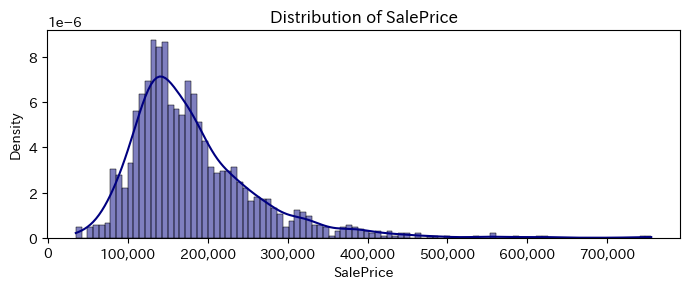

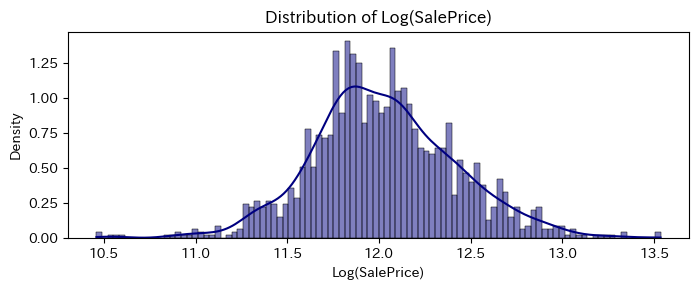

In [6]:
# targetの確認(trainにしかないcolumnが他にないかも確認)
print(set(train_df.columns) - set(test_df.columns))

# 事前にcfgを定義しておく
print(cfg.target)


# targetの分布を確認
# NOTE: 目的は分布の形状を確認することと、外れ値を確認すること
fig, ax = plt.subplots(figsize=(7, 3))
sns.histplot(train_df[cfg.target], bins=100, kde=True, ax=ax, color="navy", stat="density")

ax.set_title(f"Distribution of {cfg.target}", fontsize=12)
ax.set_xlabel(cfg.target, fontsize=10)
ax.set_ylabel("Density", fontsize=10)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.tick_params(axis="both", which="major", labelsize=10)
plt.tight_layout()
plt.show()


# NOTE: 今回の評価指標は対数スケールなのでlogを取ったtargetの分布を確認
log_target = train_df[cfg.target].log1p()

fig, ax = plt.subplots(figsize=(7, 3))
sns.histplot(log_target, bins=100, kde=True, ax=ax, color="navy", stat="density")
ax.set_title(f"Distribution of Log({cfg.target})", fontsize=12)
ax.set_xlabel(f"Log({cfg.target})", fontsize=10)
ax.set_ylabel("Density", fontsize=10)
ax.tick_params(axis="both", which="major", labelsize=10)
plt.tight_layout()
plt.show()


--- 1. 欠損値の確認 ---
■ 学習データ (train_df) の欠損値
学習データに欠損値のある列はありません。
■ テストデータ (test_df) の欠損値


column,missing_count
str,u32
"""PoolQC""",1456
"""MiscFeature""",1408
"""Alley""",1352
"""Fence""",1169
"""FireplaceQu""",730
…,…
"""TotalBsmtSF""",1
"""KitchenQual""",1
"""GarageCars""",1


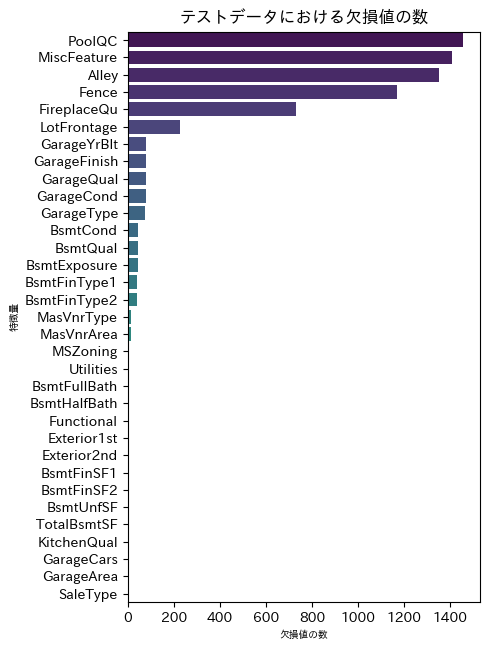

In [7]:
# 1. 欠損値の詳細な確認と可視化
print("--- 1. 欠損値の確認 ---")
missing_train_df = (
    train_df.null_count().transpose(include_header=True, header_name="column").rename({"column_0": "missing_count"})
)
missing_train_df = missing_train_df.filter(pl.col("missing_count") > 0).sort("missing_count", descending=True)

print("■ 学習データ (train_df) の欠損値")
if missing_train_df.shape[0] > 0:
    display(missing_train_df)
    fig, ax = plt.subplots(figsize=(10, max(4, missing_train_df.shape[0] * 0.3)))  # プロット数を考慮して高さを調整
    sns.barplot(x="missing_count", y="column", data=missing_train_df.to_pandas(), ax=ax, palette="viridis")
    ax.set_title("学習データにおける欠損値の数", fontsize=15)
    ax.set_xlabel("欠損値の数", fontsize=12)
    ax.set_ylabel("特徴量", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("学習データに欠損値のある列はありません。")


missing_test_df = (
    test_df.null_count().transpose(include_header=True, header_name="column").rename({"column_0": "missing_count"})
)
missing_test_df = missing_test_df.filter(pl.col("missing_count") > 0).sort("missing_count", descending=True)

print("■ テストデータ (test_df) の欠損値")
if missing_test_df.shape[0] > 0:
    display(missing_test_df)
    fig, ax = plt.subplots(figsize=(5, max(4, missing_test_df.shape[0] * 0.2)))
    sns.barplot(
        x="missing_count",
        y="column",
        hue="column",
        data=missing_test_df.to_pandas(),
        ax=ax,
        palette="viridis",
        legend=False,
    )
    ax.set_title("テストデータにおける欠損値の数", fontsize=12)
    ax.set_xlabel("欠損値の数", fontsize=7)
    ax.set_ylabel("特徴量", fontsize=7)
    plt.tight_layout()
    plt.show()
else:
    print("テストデータに欠損値のある列はありません。")


- testのみ欠損値があることがわかりました
  - どのように欠損値を処理するか考える必要があります
  - 欠損値の処理方法は、特徴量の種類によって異なる場合があります
  - また、testデータに欠損値がある場合はtrainデータの平均値や最頻値などを使って補完することが多いです
    - testデータの分布は未知です


### 質的変数と量的変数の確認
- 変数には質的変数(カテゴリカル変数)と量的変数(数値変数)があります
  - 質的変数は、カテゴリカルデータとも呼ばれ、数値ではなく、文字列やラベルで表現される変数です
  - 量的変数は、数値で表現される変数です
- 質的変数は名義尺度と順序尺度に分けられます
  - 名義尺度は、順序がないカテゴリカルデータです
    - 例: 性別、血液型、国名など 
  - 順序尺度は、順序があるカテゴリカルデータです
    - 例: 満足度、評価など
- 量的変数は、間隔尺度と比率尺度に分けられます
- 間隔尺度は、順序があり、数値の差が意味を持つデータで、絶対的な0が存在しないものです
  - 例: 時間、セルシウス温度など
- 比率尺度は、順序があり、数値の比が意味を持つデータです、ゼロがしっかり無を意味するものです
  - 例: 身長、体重、距離、絶対温度など


まずは単純にpolarsのdatatypeがpl.Utf8もしくはpl.Categoryであるものを質的変数とし、それ以外を量的変数とします。  
今回のようにデータの説明情報(`data_description.txt`)がある場合はそれを参考にするのが一番良いです。  

In [8]:
# カテゴリカル変数と数値変数の列を取得
categorical_columns = [
    col for col in train_df.columns if train_df[col].dtype == pl.Categorical or train_df[col].dtype == pl.Utf8
]
numerical_columns = [
    col
    for col in train_df.columns
    if col not in categorical_columns
    and col != cfg.target
    and col != "Id"
    and train_df[col].dtype not in [pl.Categorical, pl.Utf8]
]

print(f"categorical_columns: {len(categorical_columns)}")
print(f"numerical_columns: {len(numerical_columns)}")


categorical_columns: 46
numerical_columns: 33


まずは量的変数のEDAを行います

1. まずはデータの分布の確認を行います
2. 今回、目的変数が量的変数であるため、量的変数同士は相関係数が計算できます

--- 数値変数の分布確認---


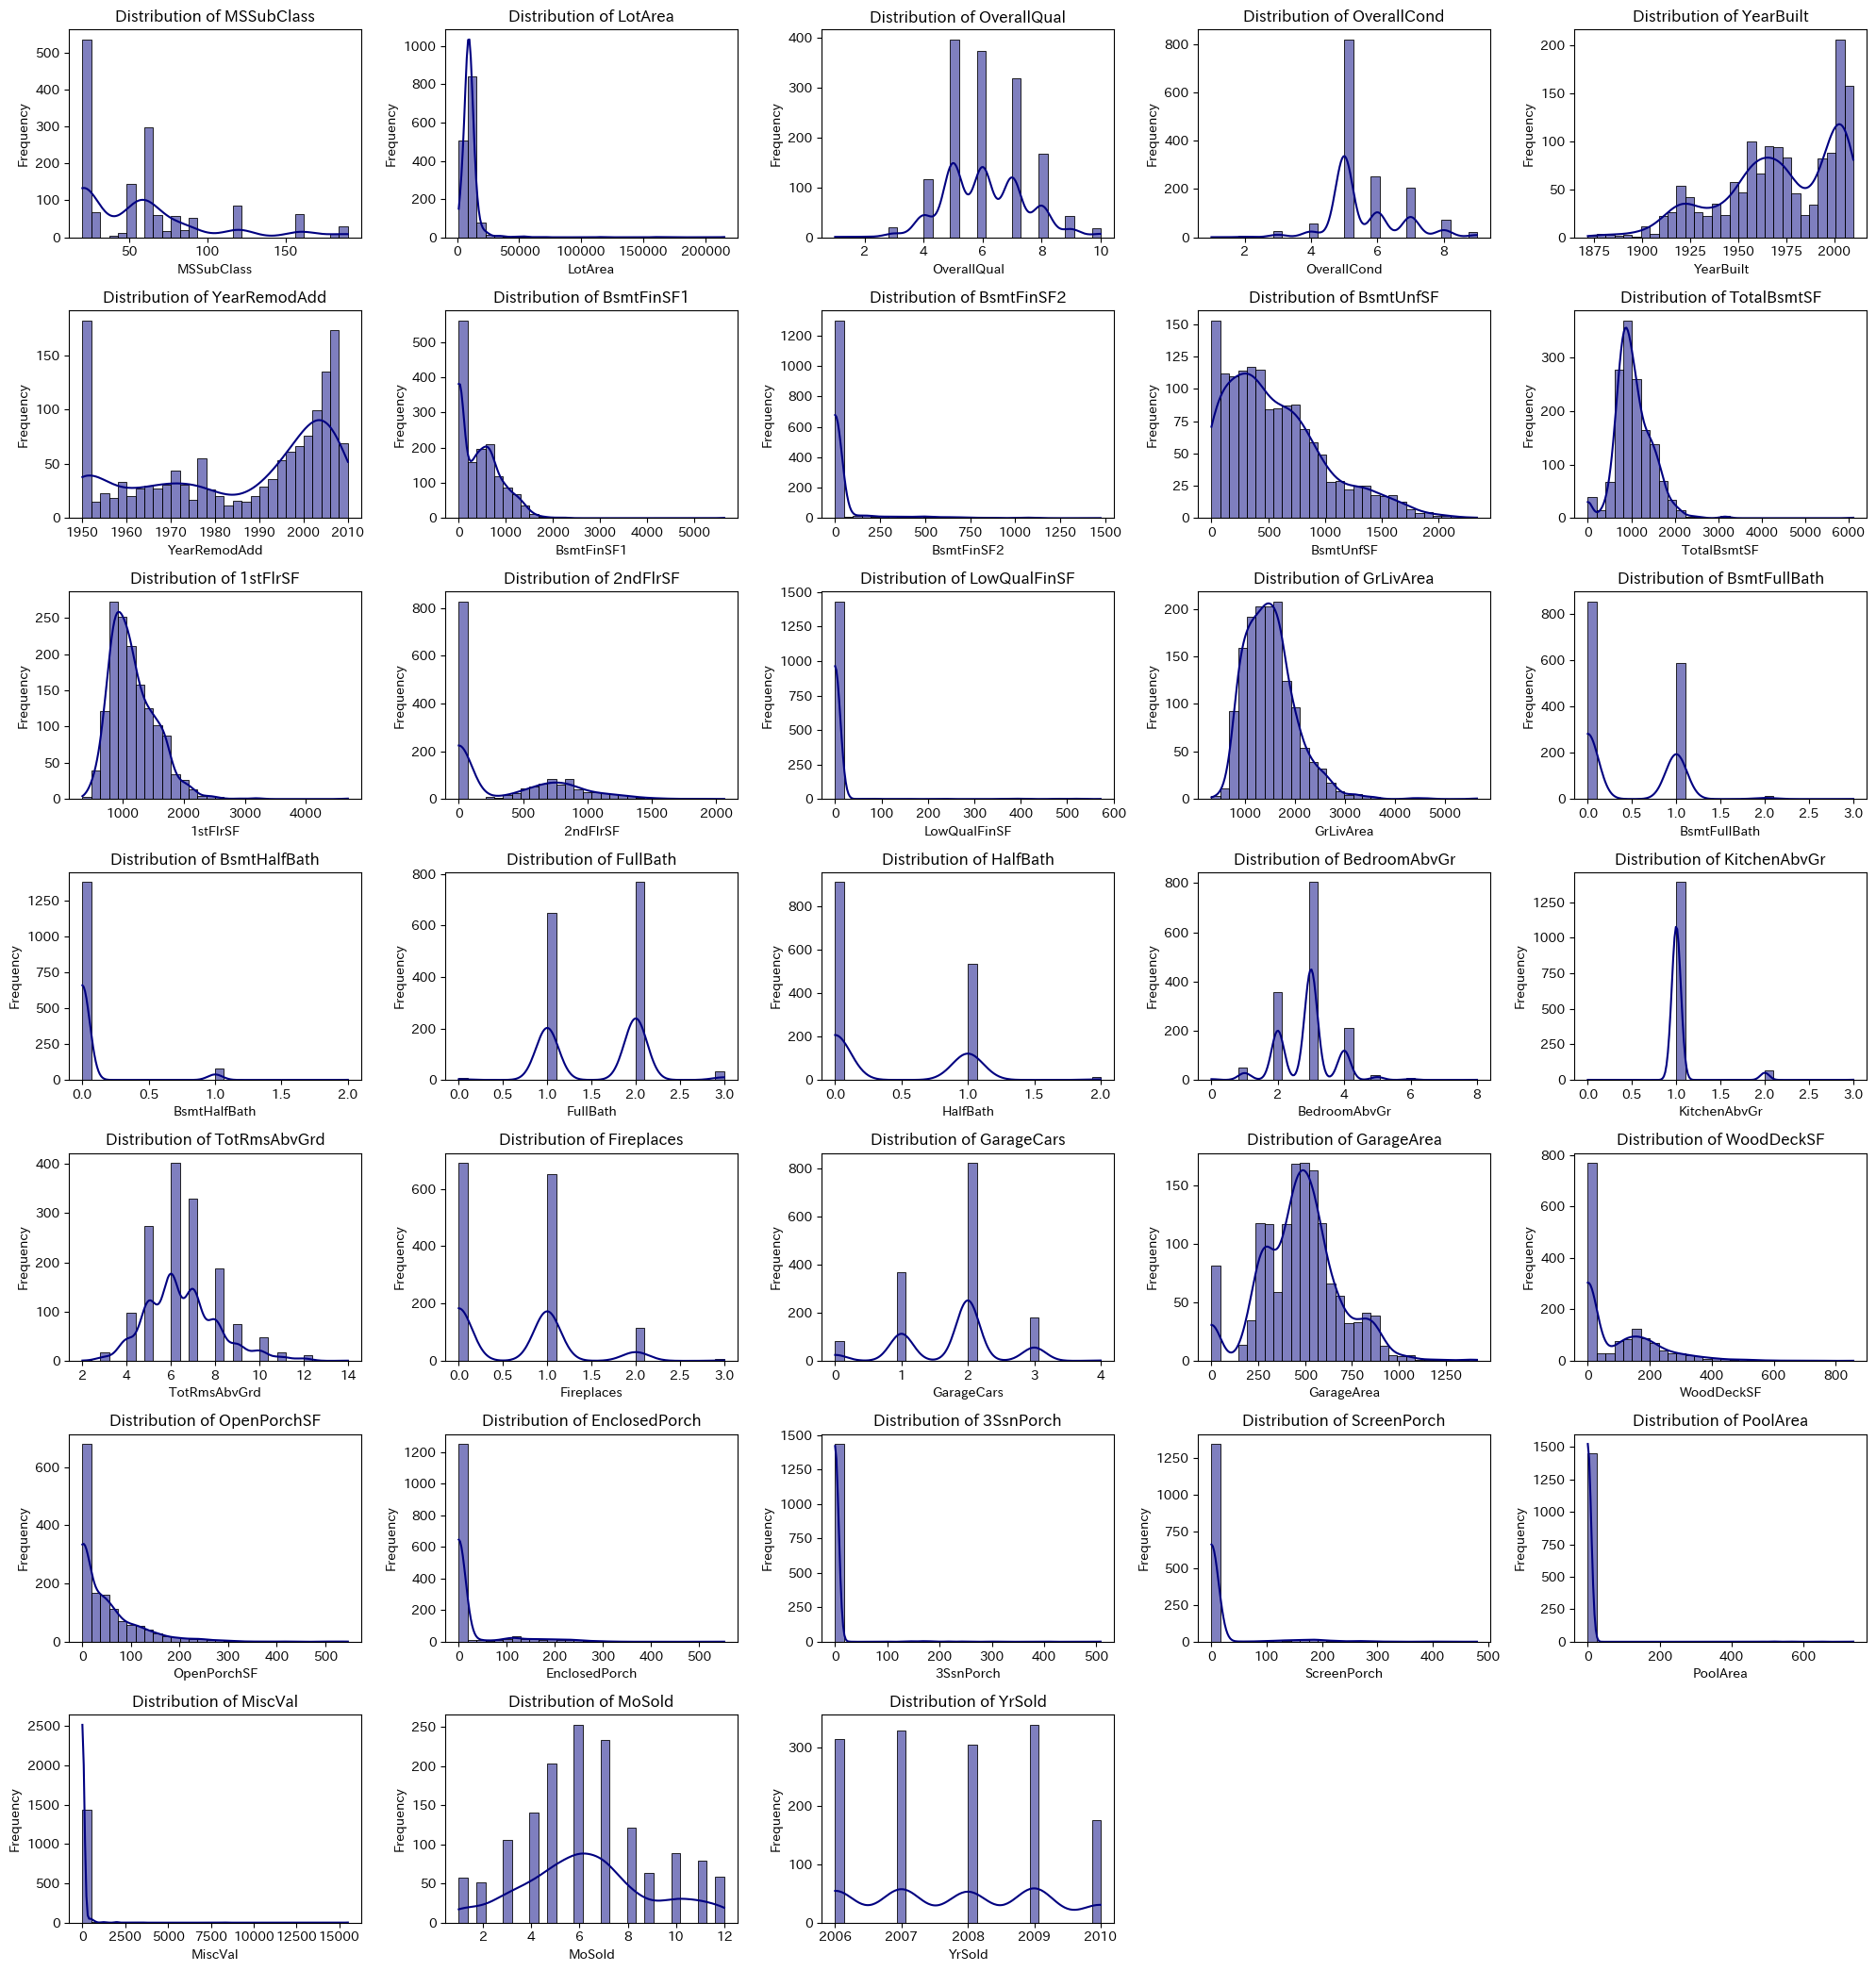

In [9]:
# numerical変数のEDA 1
print("--- 数値変数の分布確認---")
# NOTE: 全ての数値変数について、そのデータ分布の形状をヒストグラムとカーネル密度推定(KDE)を用いて網羅的に可視化する。
# NOTE: 各変数が正規分布に近いか、左右どちらかに歪んでいるか、複数のピークを持つか、裾が重い（外れ値が多い）かなどを確認し、
# NOTE: 特徴量変換（対数変換、標準化など）の必要性や、モデリング時の注意点を把握するための基礎情報を得ることを目的とする。
ncols = 5
nrows = (len(numerical_columns) + ncols - 1) // ncols

fig_w = ncols * 4
fig_h = nrows * 3

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)
axes_flat = axes.flatten()

for i, col in enumerate(numerical_columns):
    ax = axes_flat[i]
    sns.histplot(train_df[col].drop_nulls(), bins=30, kde=True, ax=ax, color="navy")
    ax.set_title(f"Distribution of {col}", fontsize=12)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.tick_params(axis="both", which="major", labelsize=10)

# 使用されなかった余分なサブプロットを非表示にする
for i in range(len(numerical_columns), len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()


ターゲット変数 (SalePrice) との相関が高い数値変数:
OverallQual: 0.7910
GrLivArea: 0.7086
GarageCars: 0.6404
GarageArea: 0.6234
TotalBsmtSF: 0.6136
1stFlrSF: 0.6059
FullBath: 0.5607
TotRmsAbvGrd: 0.5337
YearBuilt: 0.5229
YearRemodAdd: 0.5071
Fireplaces: 0.4669
BsmtFinSF1: 0.3864
WoodDeckSF: 0.3244
2ndFlrSF: 0.3193
OpenPorchSF: 0.3159

■ 相関のある全数値変数 (上位 33 件) と SalePrice の散布図 (Grid Layout)


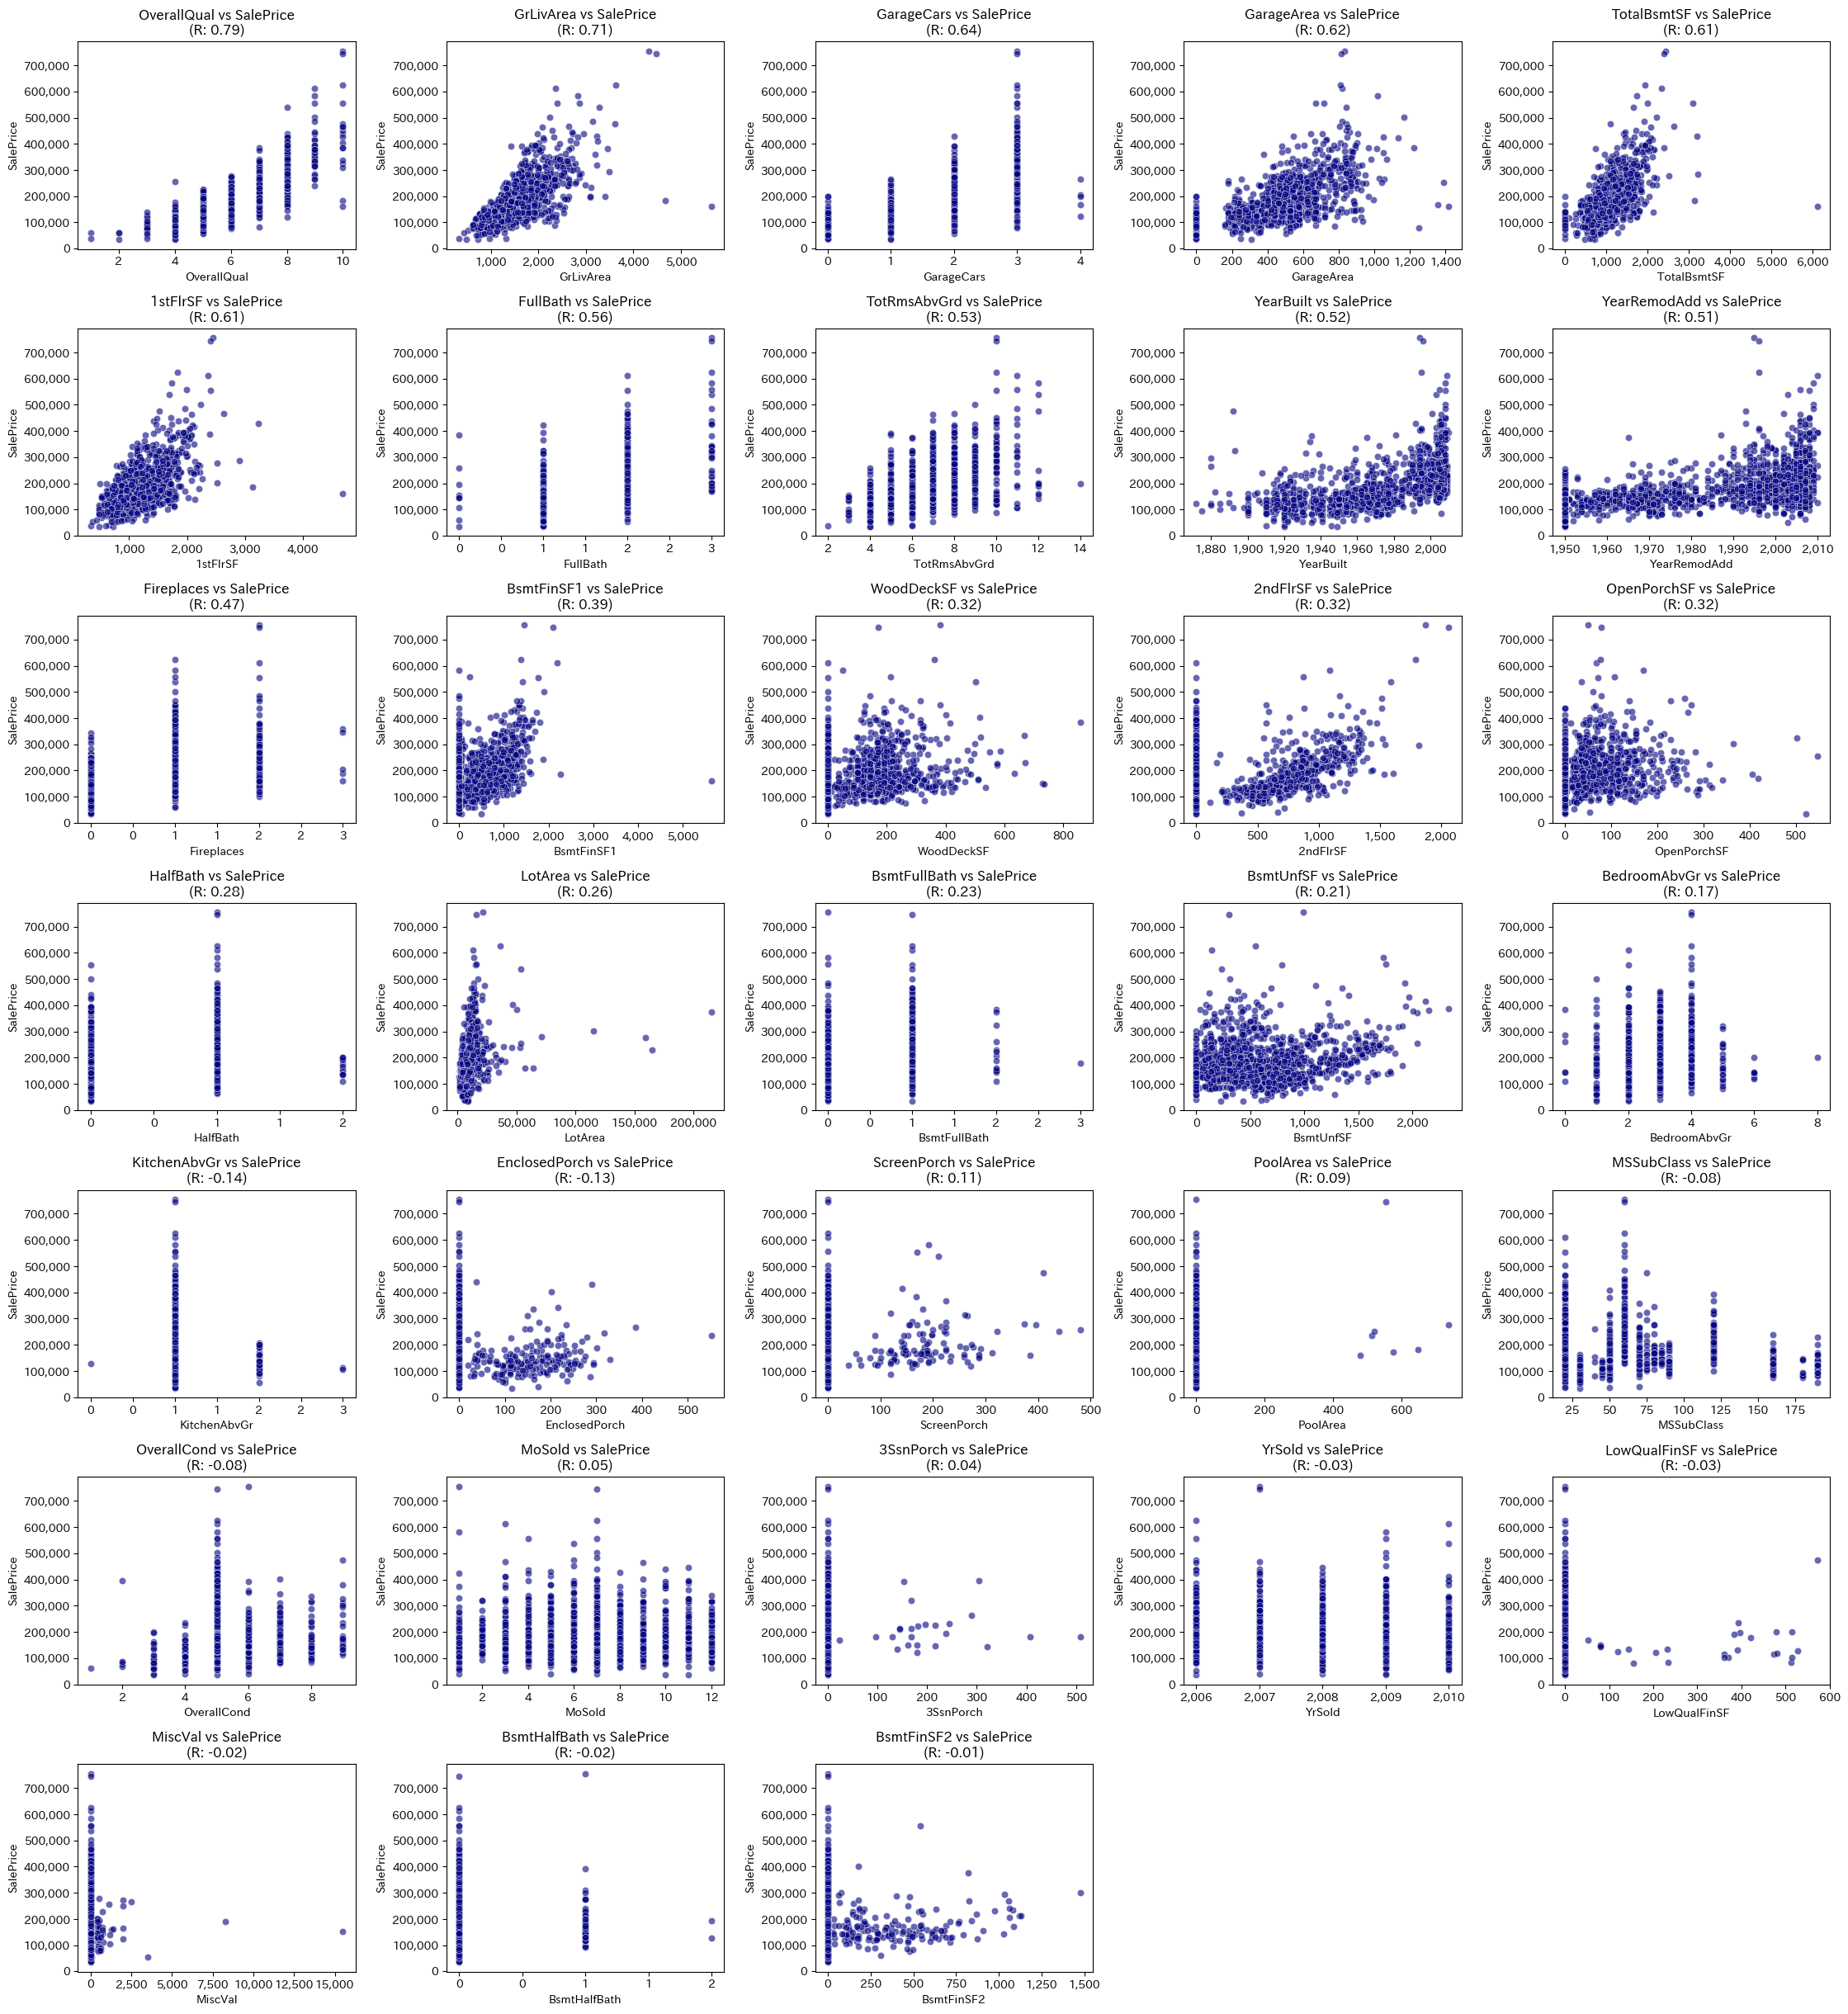

In [10]:
# numerical変数のEDA 2
# NOTE: ターゲット変数に対する各数値変数の相関の強さを定量的にリストアップし、
# NOTE: さらに、相関が計算できた全ての数値変数とターゲット変数との関係性を散布図で網羅的に可視化する。
# NOTE: モデル構築に重要な特徴量の初期的な全体像を把握することを目的とする。

numerical_correlations = []
for col in numerical_columns:
    correlation = train_df.select(pl.corr(pl.col(col), pl.col(cfg.target))).item()
    # if correlation is not None and not (isinstance(correlation, float) and np.isnan(correlation)):
    numerical_correlations.append((col, correlation))

sorted_correlations = sorted(numerical_correlations, key=lambda x: abs(x[1]), reverse=True)

print(f"ターゲット変数 ({cfg.target}) との相関が高い数値変数:")
for col_name, corr_val in sorted_correlations[:15]:
    print(f"{col_name}: {corr_val:.4f}")

num_display_col = len(sorted_correlations)

print(f"\n■ 相関のある全数値変数 (上位 {num_display_col} 件) と {cfg.target} の散布図 (Grid Layout)")
scatter_targets = sorted_correlations[:num_display_col]
num_scatters = len(scatter_targets)

ncols = 5
nrows = (num_scatters + ncols - 1) // ncols

fig_w = ncols * 4.5
fig_h = nrows * 3.5

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)
axes_flat = axes.flatten()

for i, (col_name, corr_val) in enumerate(scatter_targets):
    ax = axes_flat[i]
    df_plot = train_df.select([pl.col(col_name), pl.col(cfg.target)]).drop_nulls()

    sns.scatterplot(data=df_plot, x=col_name, y=cfg.target, ax=ax, alpha=0.6, color="navy")
    ax.set_title(f"{col_name} vs {cfg.target}\n(R: {corr_val:.2f})", fontsize=12)
    ax.set_xlabel(col_name, fontsize=10)
    ax.set_ylabel(cfg.target, fontsize=10)
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

    if df_plot[col_name].dtype != pl.Boolean:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

for i in range(num_scatters, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()


■ 数値変数の相関行列ヒートマップ (ターゲットを先頭に表示)


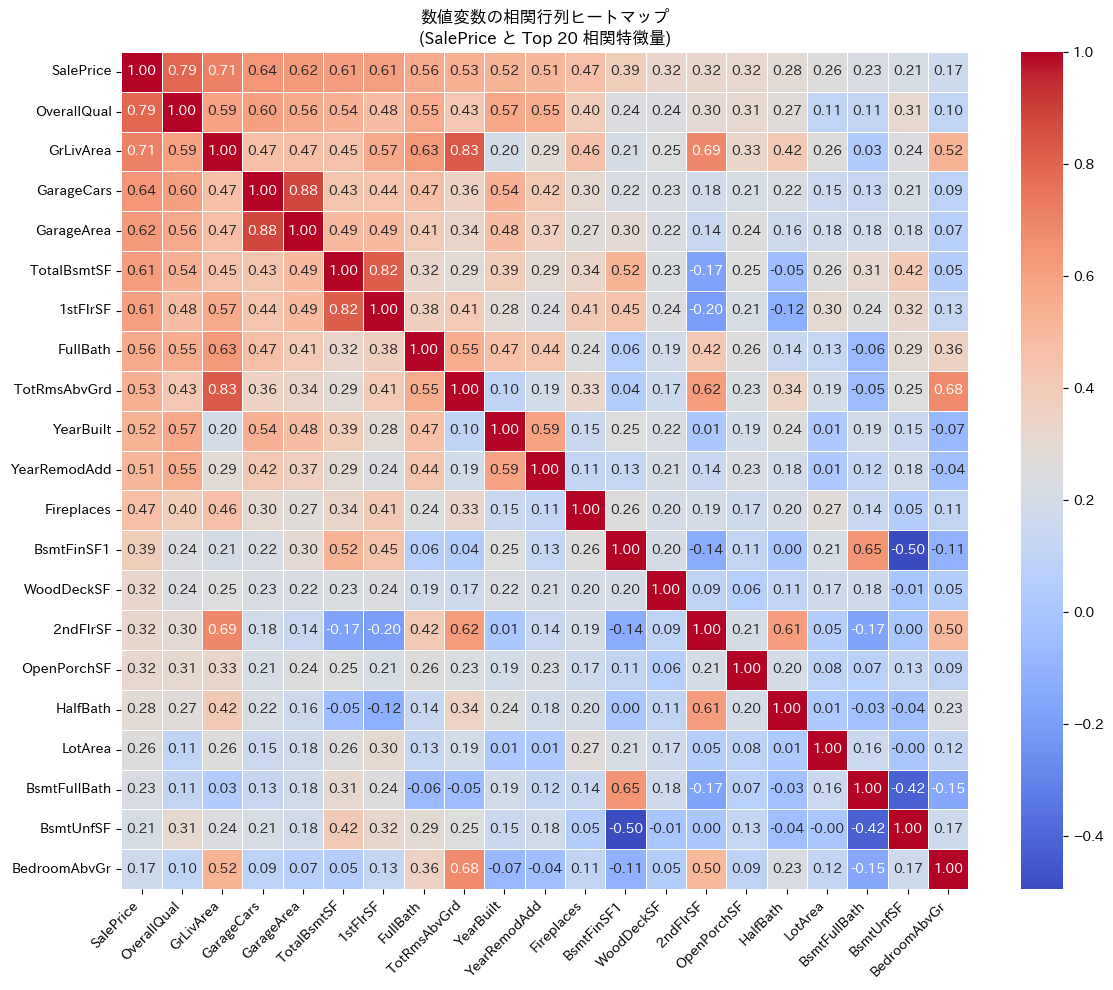

In [11]:
print("■ 数値変数の相関行列ヒートマップ (ターゲットを先頭に表示)")

top_n_feats = [item[0] for item in sorted_correlations[:20]]

ordered_cols = [cfg.target]
for feat in top_n_feats:
    if feat != cfg.target and feat not in ordered_cols:
        ordered_cols.append(feat)

df_heatmap = train_df.select(ordered_cols).drop_nulls()
corr_matrix = df_heatmap.to_pandas().corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
num_other_feats = len(ordered_cols) - 1
plt.title(
    f"数値変数の相関行列ヒートマップ\n({cfg.target} と Top {num_other_feats} 相関特徴量)",
    fontsize=12,
)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


--- 3. カテゴリカル変数とターゲット変数の関係分析 ---


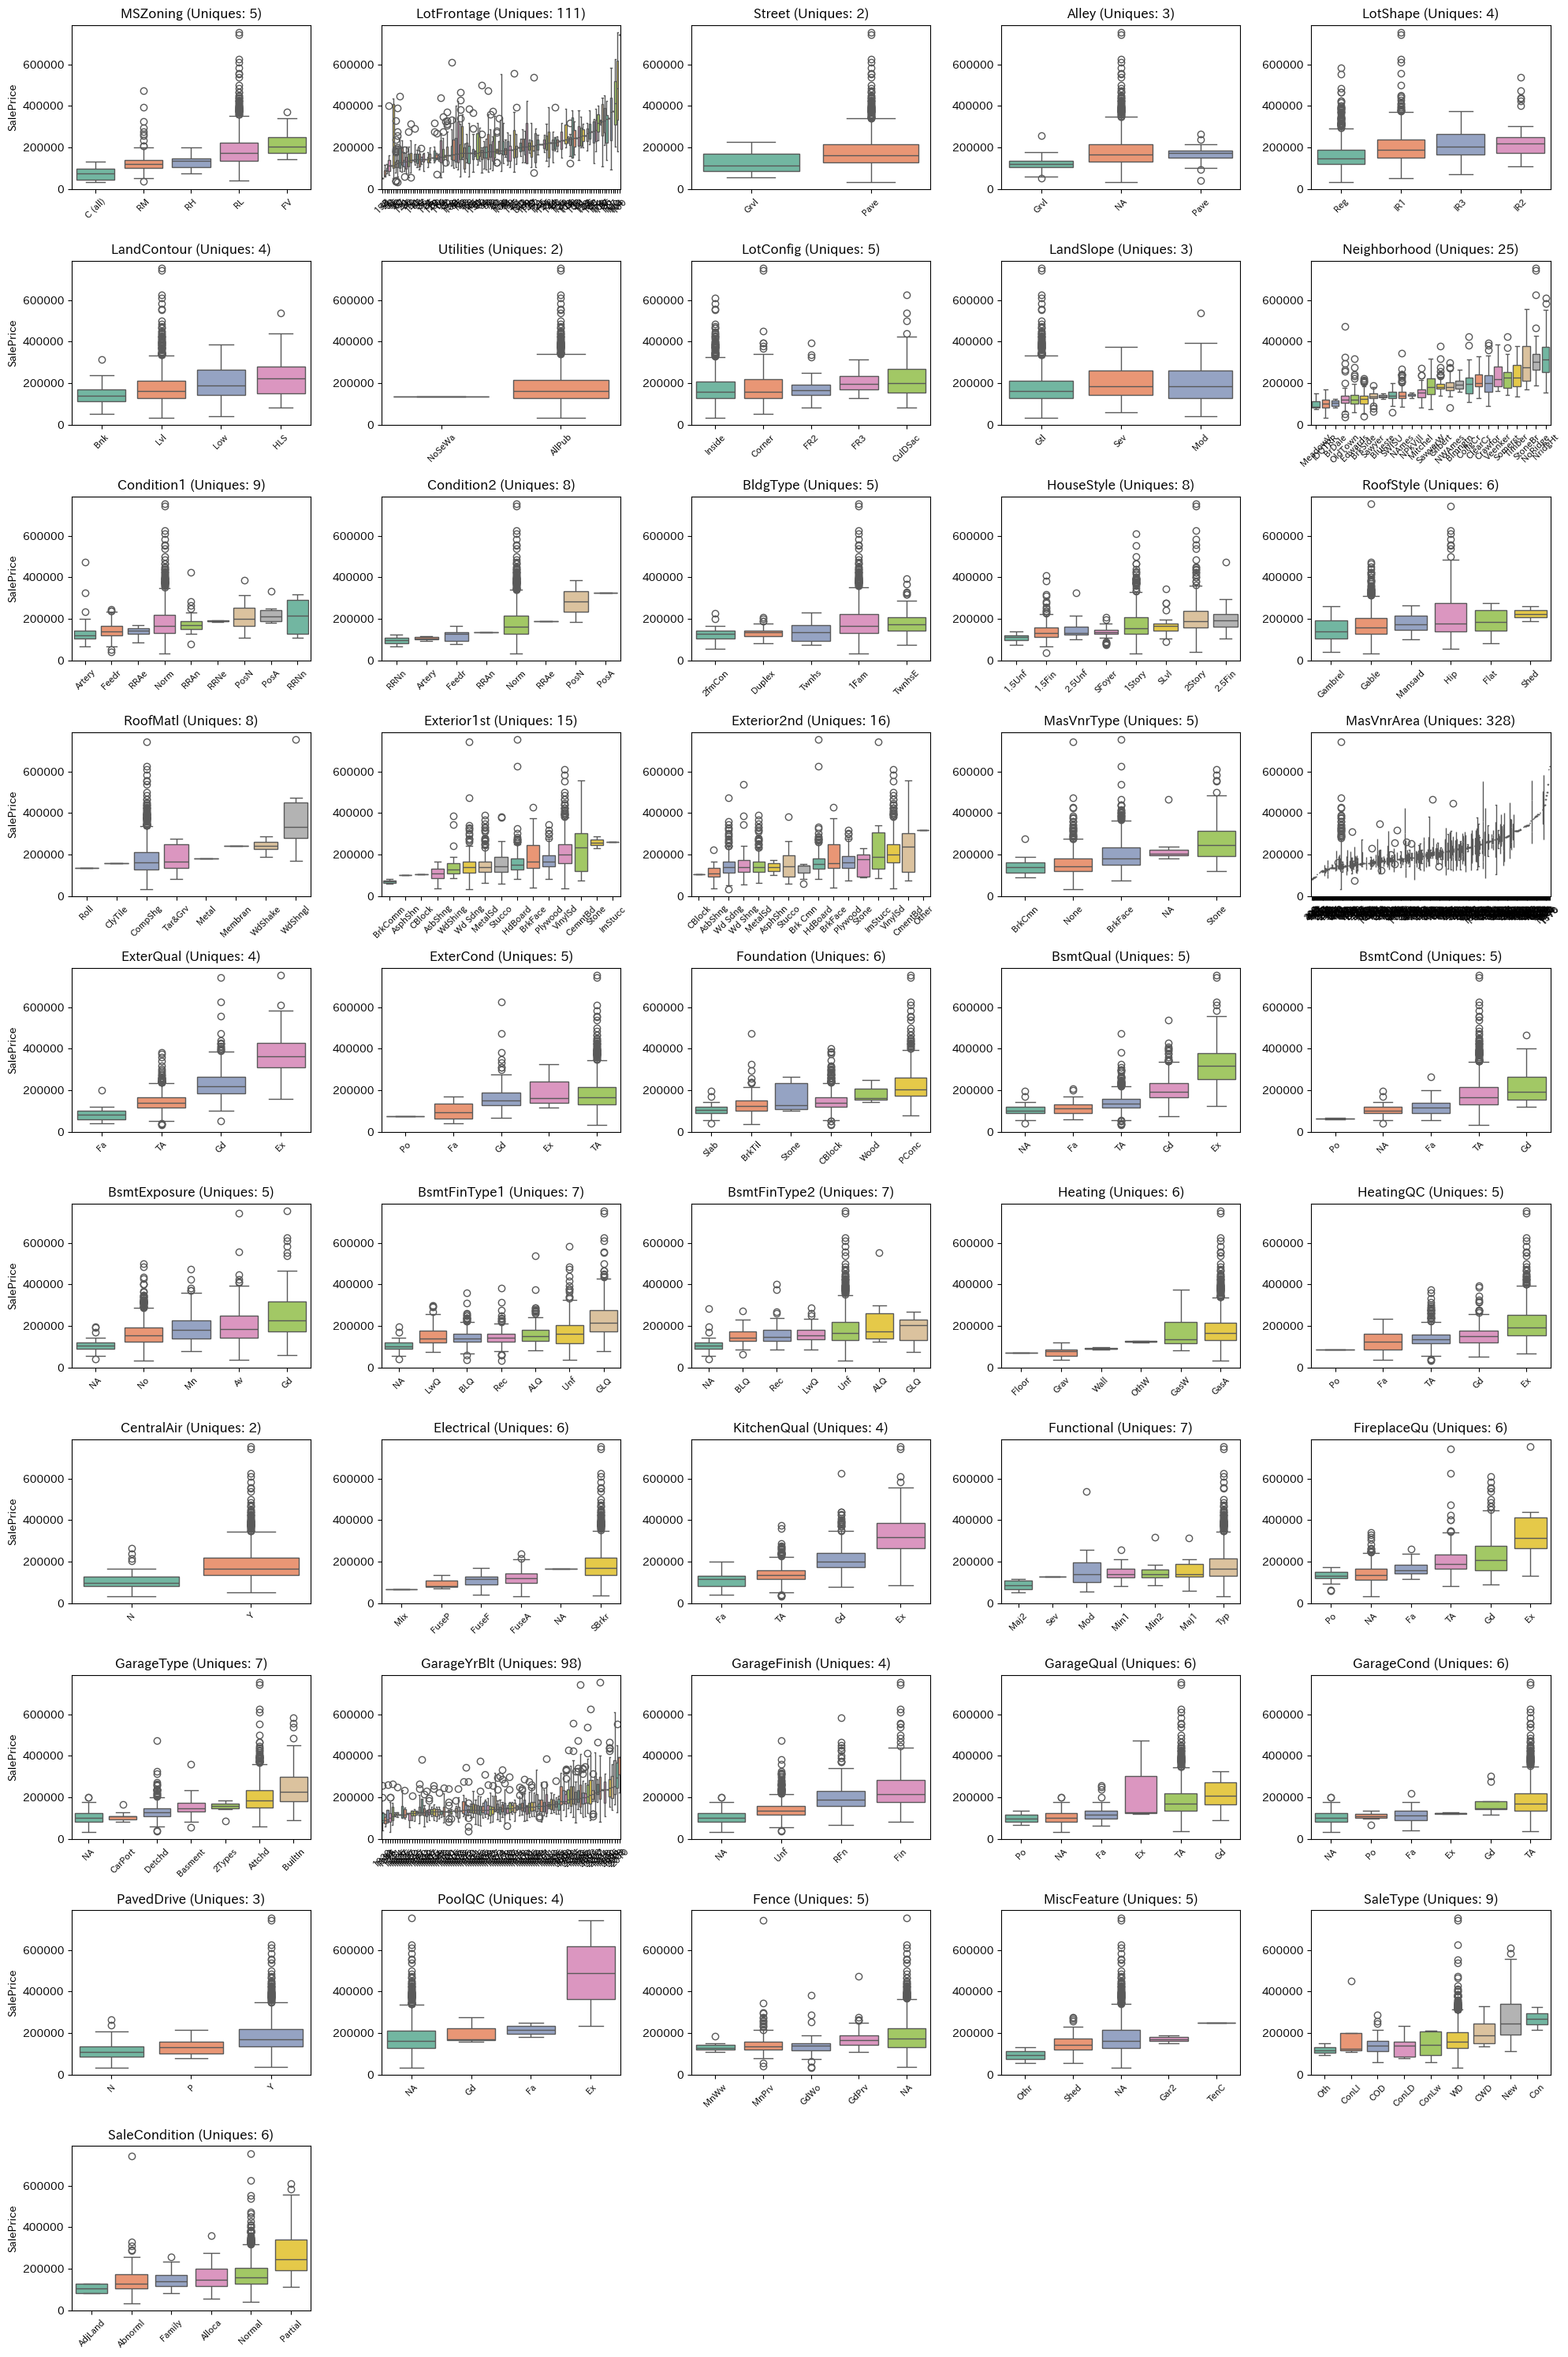

In [12]:
print("--- 3. カテゴリカル変数とターゲット変数の関係分析 ---")
# NOTE: 全てのカテゴリカル変数について、その各カテゴリ（水準）がターゲット変数の分布にどのような影響を与えるかを箱ひげ図で網羅的に可視化する。
# NOTE: これにより、カテゴリごとのターゲット変数の中央値、四分位数範囲、外れ値の傾向を比較し、
# NOTE: 価格と強い関連性を持つ可能性のある特徴量やカテゴリを特定することを目的とする。
# NOTE: また、ユニークカテゴリ数も確認し、エンコーディング戦略の参考にする。
num_cat_features = len(categorical_columns)
ncols = 5
nrows = (num_cat_features + ncols - 1) // ncols

fig_width_total = ncols * 4.0
fig_height_total = nrows * 3.0

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width_total, fig_height_total), squeeze=False)
axes_flat = axes.flatten()

for i, col in enumerate(categorical_columns):
    ax = axes_flat[i]
    unique_count = train_df[col].drop_nulls().n_unique()

    df_plot = train_df.select([pl.col(col), pl.col(cfg.target)]).drop_nulls()

    ord_df = (
        df_plot.lazy()
        .group_by(col)
        .agg(pl.median(cfg.target).alias("median_val"))
        .sort("median_val")
        .select(col)
        .collect()
    )
    order = ord_df[col].to_list() if not ord_df.is_empty() and col in ord_df.columns else None

    sns.boxplot(data=df_plot, x=col, y=cfg.target, ax=ax, order=order, palette="Set2")
    ax.set_title(f"{col} (Uniques: {unique_count})", fontsize=12)
    ax.set_xlabel(None)

    if i % ncols == 0:
        ax.set_ylabel(cfg.target, fontsize=10)
    else:
        ax.set_ylabel(None)

    ax.tick_params(axis="y", which="major", labelsize=10)
    ax.tick_params(axis="x", which="major", labelsize=8, labelrotation=45)

for i in range(num_cat_features, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()


可視化をすることで数値であってもじつはユニーク数が少なく質的変数であることがわかる場合もあります。  
また、それが間隔尺度なのか比率尺度なのかも可視化することでわかる場合があります。

今回は`data_description.txt`を基にLLMで分類をしました

In [13]:
categorical_columns = [
    "MSSubClass",  # 数値だが、建物の種類を表すカテゴリコード
    "MSZoning",
    "Street",
    "Alley",  # NAは「No alley access」というカテゴリ
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "OverallQual",  # 1-10の評価 (順序カテゴリカル)
    "OverallCond",  # 1-10の評価 (順序カテゴリカル)
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",  # Noneは「None」というカテゴリ
    "ExterQual",  # 評価 (順序カテゴリカル)
    "ExterCond",  # 評価 (順序カテゴリカル)
    "Foundation",
    "BsmtQual",  # 評価 (NAは「No Basement」カテゴリ、順序カテゴリカル)
    "BsmtCond",  # 評価 (NAは「No Basement」カテゴリ、順序カテゴリカル)
    "BsmtExposure",  # 評価 (NAは「No Basement」カテゴリ、順序カテゴリカル)
    "BsmtFinType1",  # 評価 (NAは「No Basement」カテゴリ、順序カテゴリカル)
    "BsmtFinType2",  # 評価 (NAは「No Basement」カテゴリ、順序カテゴリカル)
    "Heating",
    "HeatingQC",  # 評価 (順序カテゴリカル)
    "CentralAir",  # Y/N
    "Electrical",  # NAを含む可能性、カテゴリとして扱うのが一般的
    "KitchenQual",  # 評価 (順序カテゴリカル)
    "Functional",  # 評価 (順序カテゴリカル)
    "FireplaceQu",  # 評価 (NAは「No Fireplace」カテゴリ、順序カテゴリカル)
    "GarageType",  # NAは「No Garage」カテゴリ
    "GarageFinish",  # NAは「No Garage」カテゴリ (順序カテゴリカル)
    "GarageQual",  # NAは「No Garage」カテゴリ (順序カテゴリカル)
    "GarageCond",  # NAは「No Garage」カテゴリ (順序カテゴリカル)
    "PavedDrive",  # Y/P/N
    "PoolQC",  # NAは「No Pool」カテゴリ (順序カテゴリカル)
    "Fence",  # NAは「No Fence」カテゴリ (順序カテゴリカル)
    "MiscFeature",  # NAは「None」カテゴリ
    "SaleType",
    "SaleCondition",
]

numerical_columns = [
    "LotFrontage",  # Linear feet of street connected to property
    "LotArea",  # Lot size in square feet
    "YearBuilt",  # Original construction date
    "YearRemodAdd",  # Remodel date
    "MasVnrArea",  # Masonry veneer area in square feet
    "BsmtFinSF1",  # Type 1 finished square feet
    "BsmtFinSF2",  # Type 2 finished square feet
    "BsmtUnfSF",  # Unfinished square feet of basement area
    "TotalBsmtSF",  # Total square feet of basement area
    "1stFlrSF",  # First Floor square feet
    "2ndFlrSF",  # Second floor square feet
    "LowQualFinSF",  # Low quality finished square feet (all floors)
    "GrLivArea",  # Above grade (ground) living area square feet
    "BsmtFullBath",  # Basement full bathrooms (個数)
    "BsmtHalfBath",  # Basement half bathrooms (個数)
    "FullBath",  # Full bathrooms above grade (個数)
    "HalfBath",  # Half baths above grade (個数)
    "BedroomAbvGr",  # Bedrooms above grade (個数)
    "KitchenAbvGr",  # Kitchens above grade (個数)
    "TotRmsAbvGrd",  # Total rooms above grade (does not include bathrooms) (個数)
    "Fireplaces",  # Number of fireplaces (個数)
    "GarageYrBlt",  # Year garage was built
    "GarageCars",  # Size of garage in car capacity (個数)
    "GarageArea",  # Size of garage in square feet
    "WoodDeckSF",  # Wood deck area in square feet
    "OpenPorchSF",  # Open porch area in square feet
    "EnclosedPorch",  # Enclosed porch area in square feet
    "3SsnPorch",  # Three season porch area in square feet
    "ScreenPorch",  # Screen porch area in square feet
    "PoolArea",  # Pool area in square feet
    "MiscVal",  # $Value of miscellaneous feature
    "MoSold",  # Month Sold (MM)
    "YrSold",  # Year Sold (YYYY)
]


In [14]:
# 名義尺度、順序尺度、間隔尺度、比率尺度の4つに分類したもの
# 前処理を行う際に、これらの情報を参考にすることができるかも

nominal_columns = [
    "MSSubClass",  # 数値コードだが、順序性のない建物の種類の分類
    "MSZoning",  # 地域区分 (例: RL, RM)
    "Street",  # 道路の種類 (例: Pave, Grvl)
    "Alley",  # 路地の種類 (例: Pave, Grvl, NA)
    "LotShape",  # 敷地の形状 (例: Reg, IR1)
    "LandContour",  # 敷地の平坦度 (例: Lvl, Bnk)
    "Utilities",  # 利用可能な設備 (例: AllPub, NoSewr)
    "LotConfig",  # 区画の配置 (例: Inside, Corner)
    "LandSlope",  # 敷地の傾斜 (例: Gtl, Mod)
    "Neighborhood",  # 近隣地域名
    "Condition1",  # 近接状況1 (例: Norm, Feedr)
    "Condition2",  # 近接状況2 (例: Norm, Feedr)
    "BldgType",  # 住居の種類 (例: 1Fam, Twnhs)
    "HouseStyle",  # 住居のスタイル (例: 1Story, 2Story)
    "RoofStyle",  # 屋根のタイプ (例: Gable, Hip)
    "RoofMatl",  # 屋根の材質
    "Exterior1st",  # 外装材1
    "Exterior2nd",  # 外装材2
    "MasVnrType",  # 石積みベニヤの種類 (Noneはカテゴリ)
    "Foundation",  # 基礎の種類
    "Heating",  # 暖房の種類
    "CentralAir",  # セントラルエアコンの有無 (Y/N)
    "Electrical",  # 電気系統の種類
    "GarageType",  # ガレージの種類 (NAはカテゴリ)
    "PavedDrive",  # 舗装された私道 (Y/P/N)
    "MiscFeature",  # その他の特徴 (NAはカテゴリ)
    "SaleType",  # 販売の種類
    "SaleCondition",  # 販売の条件
]

ordinal_columns = [
    "OverallQual",  # 全体的な材質と仕上げの品質 (1-10段階)
    "OverallCond",  # 全体的な状態評価 (1-10段階)
    "ExterQual",  # 外装材の品質 (Ex, Gd, TA, Fa, Po)
    "ExterCond",  # 外装材の現在の状態 (Ex, Gd, TA, Fa, Po)
    "BsmtQual",  # 地下室の高さの評価 (Ex, Gd, TA, Fa, Po, NA)
    "BsmtCond",  # 地下室の全体的な状態 (Ex, Gd, TA, Fa, Po, NA)
    "BsmtExposure",  # 地下室の壁の露出度 (Gd, Av, Mn, No, NA)
    "BsmtFinType1",  # 地下室の仕上げ済みエリアの評価1 (GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA)
    "BsmtFinType2",  # 地下室の仕上げ済みエリアの評価2 (GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA)
    "HeatingQC",  # 暖房の品質と状態 (Ex, Gd, TA, Fa, Po)
    "KitchenQual",  # キッチンの品質 (Ex, Gd, TA, Fa, Po)
    "Functional",  # 住宅の機能性評価 (Typ, Min1, ..., Sal)
    "FireplaceQu",  # 暖炉の品質 (Ex, Gd, TA, Fa, Po, NA)
    "GarageFinish",  # ガレージの内装仕上げ (Fin, RFn, Unf, NA)
    "GarageQual",  # ガレージの品質 (Ex, Gd, TA, Fa, Po, NA)
    "GarageCond",  # ガレージの状態 (Ex, Gd, TA, Fa, Po, NA)
    "PoolQC",  # プールの品質 (Ex, Gd, TA, Fa, NA)
    "Fence",  # フェンスの品質 (GdPrv, MnPrv, GdWo, MnWw, NA)
]

interval_columns = [
    "YearBuilt",  # 建築年 (暦年)
    "YearRemodAdd",  # 改築年 (暦年)
    "GarageYrBlt",  # ガレージ建築年 (暦年)
    "MoSold",  # 販売月 (1-12月、間隔は等しいが循環的)
    "YrSold",  # 販売年 (暦年)
]

ratio_columns = [
    "LotFrontage",  # 道路に面している長さ (絶対的な0が存在)
    "LotArea",  # 敷地面積 (絶対的な0が存在)
    "MasVnrArea",  # 石積みベニヤの面積 (絶対的な0が存在)
    "BsmtFinSF1",  # タイプ1仕上げ済み地下室の面積 (絶対的な0が存在)
    "BsmtFinSF2",  # タイプ2仕上げ済み地下室の面積 (絶対的な0が存在)
    "BsmtUnfSF",  # 未仕上げの地下室の面積 (絶対的な0が存在)
    "TotalBsmtSF",  # 地下室の総面積 (絶対的な0が存在)
    "1stFlrSF",  # 1階の面積 (絶対的な0が存在)
    "2ndFlrSF",  # 2階の面積 (絶対的な0が存在)
    "LowQualFinSF",  # 低品質仕上げの面積 (絶対的な0が存在)
    "GrLivArea",  # 地上リビングエリア面積 (絶対的な0が存在)
    "BsmtFullBath",  # 地下室のフルバスルームの数 (0は「なし」)
    "BsmtHalfBath",  # 地下室のハーフバスルームの数 (0は「なし」)
    "FullBath",  # 地上階のフルバスルームの数 (0は「なし」)
    "HalfBath",  # 地上階のハーフバスルームの数 (0は「なし」)
    "BedroomAbvGr",  # 地上階の寝室数 (0は「なし」)
    "KitchenAbvGr",  # 地上階のキッチン数 (0は「なし」)
    "TotRmsAbvGrd",  # 地上階の総部屋数 (0は「なし」だが通常ありえない)
    "Fireplaces",  # 暖炉の数 (0は「なし」)
    "GarageCars",  # ガレージの収容台数 (0は「なし」)
    "GarageArea",  # ガレージの面積 (絶対的な0が存在)
    "WoodDeckSF",  # ウッドデッキの面積 (絶対的な0が存在)
    "OpenPorchSF",  # オープンポーチの面積 (絶対的な0が存在)
    "EnclosedPorch",  # 囲まれたポーチの面積 (絶対的な0が存在)
    "3SsnPorch",  # スリーシーズンポーチの面積 (絶対的な0が存在)
    "ScreenPorch",  # スクリーンポーチの面積 (絶対的な0が存在)
    "PoolArea",  # プールの面積 (絶対的な0が存在)
    "MiscVal",  # その他の特徴の価値 (絶対的な0が存在)
]


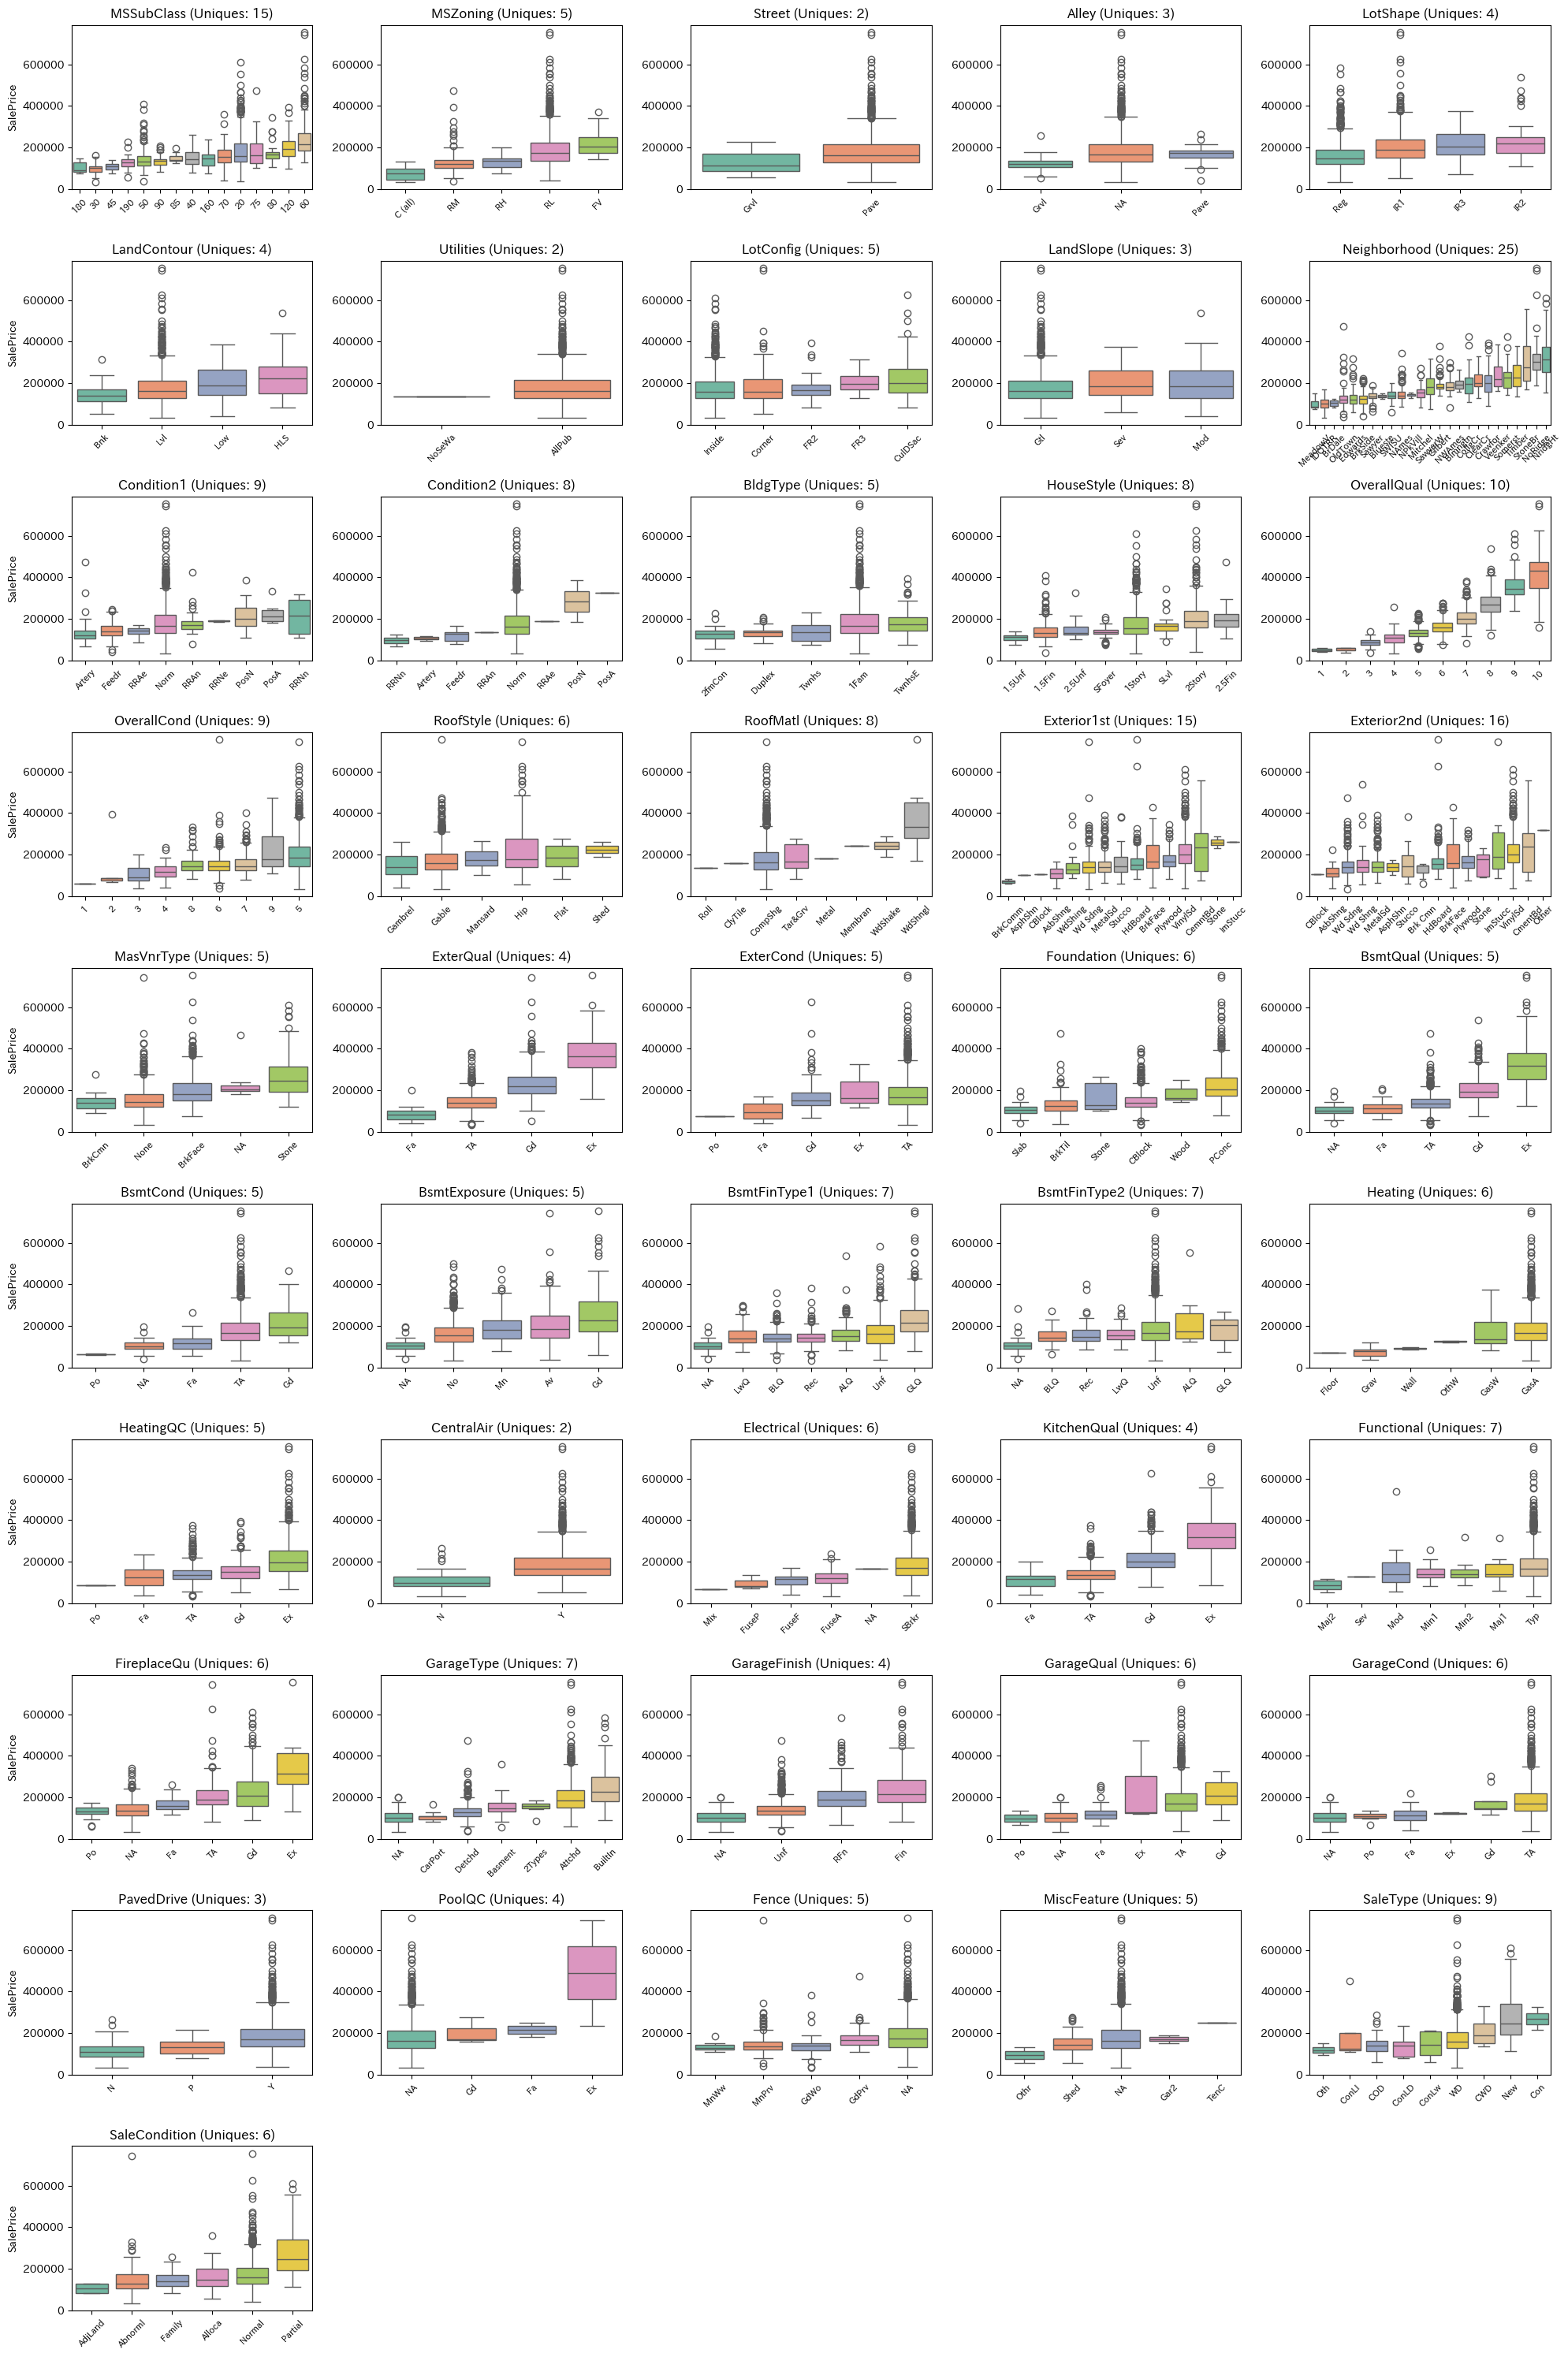

In [15]:
# 改めてカテゴリカル変数と目的変数の関係を確認します
num_cat_features = len(categorical_columns)
ncols = 5
nrows = (num_cat_features + ncols - 1) // ncols

fig_width_total = ncols * 4.0
fig_height_total = nrows * 3.0

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width_total, fig_height_total), squeeze=False)
axes_flat = axes.flatten()

for i, col in enumerate(categorical_columns):
    ax = axes_flat[i]
    unique_count = train_df[col].drop_nulls().n_unique()

    df_plot = train_df.select([pl.col(col), pl.col(cfg.target)]).drop_nulls()

    ord_df = (
        df_plot.lazy()
        .group_by(col)
        .agg(pl.median(cfg.target).alias("median_val"))
        .sort("median_val")
        .select(col)
        .collect()
    )
    order = ord_df[col].to_list() if not ord_df.is_empty() and col in ord_df.columns else None

    sns.boxplot(data=df_plot, x=col, y=cfg.target, ax=ax, order=order, palette="Set2")
    ax.set_title(f"{col} (Uniques: {unique_count})", fontsize=12)
    ax.set_xlabel(None)

    if i % ncols == 0:
        ax.set_ylabel(cfg.target, fontsize=10)
    else:
        ax.set_ylabel(None)

    ax.tick_params(axis="y", which="major", labelsize=10)
    ax.tick_params(axis="x", which="major", labelsize=8, labelrotation=45)

for i in range(num_cat_features, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()


## 発展的なEDA

これまでのEDAは基本的に単変量解析(univariate analysis)でしたが、次は多変量解析(multivariate analysis)を行います。
- 2つ以上の変数を同時に考慮して、変数間の関係を調べる手法です
- これにより特徴量を組み合わせて新しい特徴量を作成することが効果的か確認できます


例えば以下のような仮説が立ちます。

仮説: 「同じ質の家 `OverallQual` でも、`YearBuilt`(何年に建てられたか)が新しい方が価格が高いのではないか？」

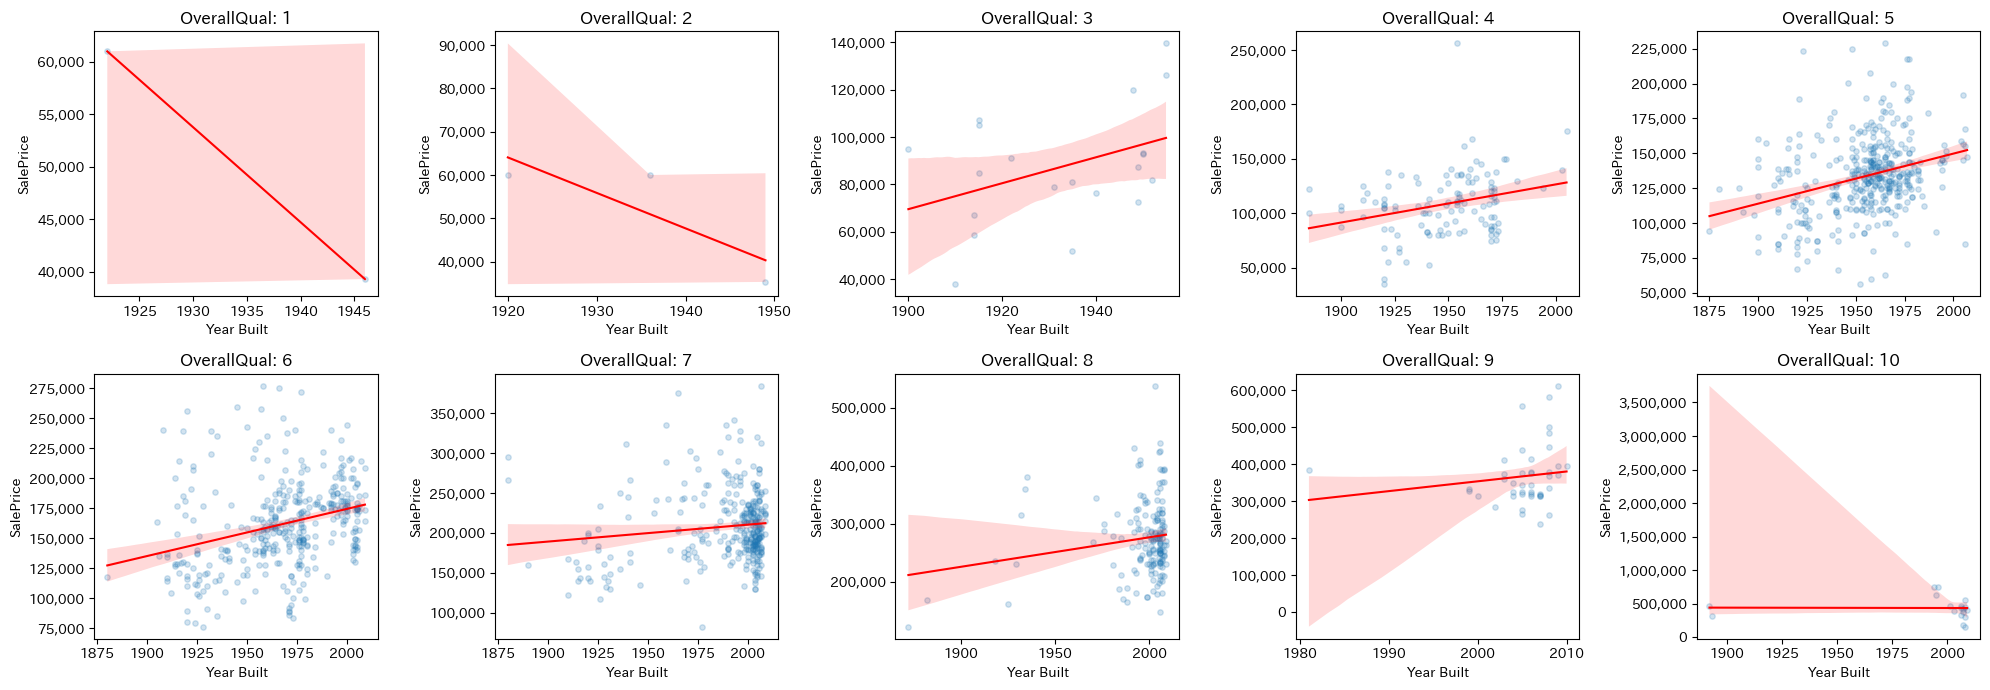

In [16]:
df_plot_data = train_df.select(
    [
        pl.col("OverallQual"),
        pl.col("YearBuilt"),
        pl.col(cfg.target),
    ]
).drop_nulls()

unique_quals = sorted(df_plot_data["OverallQual"].unique().to_list())
num_plots = len(unique_quals)

ncols = 5
nrows = (num_plots + ncols - 1) // ncols

fig_w = ncols * 4.0
fig_h = nrows * 3.5

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)
axes_flat = axes.flatten()

for i, qual_val in enumerate(unique_quals):
    ax = axes_flat[i]
    subset_data = df_plot_data.filter(pl.col("OverallQual") == qual_val)

    sns.regplot(
        data=subset_data,
        x="YearBuilt",
        y=cfg.target,
        ax=ax,
        line_kws={"color": "red", "linewidth": 1.5},
        scatter_kws={"alpha": 0.2, "s": 15},
    )
    ax.set_title(f"OverallQual: {qual_val}", fontsize=12)
    ax.set_xlabel("Year Built", fontsize=10)
    ax.set_ylabel(cfg.target, fontsize=10)
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

for i in range(num_plots, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()


同じ質の家でも築年数が浅いほど価格が高い傾向があることがわかります  
このことからそもそも築年数という特徴量が有効的であるということ  
この2つの特徴量を組み合わせて新しい特徴量をつくることがモデルの精度向上に効果的であるという仮説が立ちます

まずは販売年(`YrSold`)から建設年`YearBuilt`を引いて売れた時の築年数`HouseAge`という特徴量を作ります
    - これは予測に有効な量的変数ですと考えられます
  

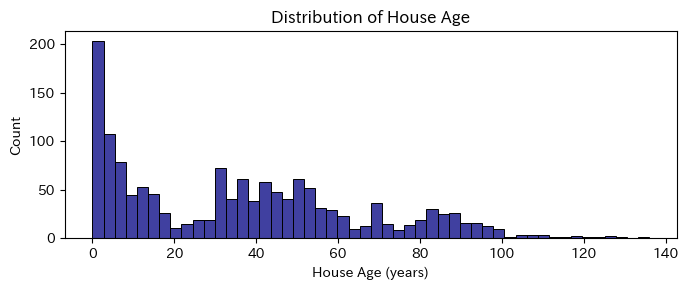

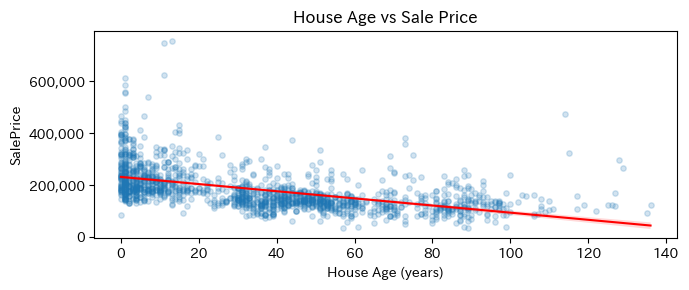

In [17]:
train_df = train_df.with_columns((pl.col("YrSold") - pl.col("YearBuilt")).alias("HouseAge"))

fig, ax = plt.subplots(figsize=(7, 3))
sns.histplot(data=train_df, x="HouseAge", bins=50, ax=ax, color="navy")
ax.set_title("Distribution of House Age", fontsize=12)
ax.set_xlabel("House Age (years)", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 3))
sns.regplot(
    data=train_df,
    x="HouseAge",
    y=cfg.target,
    ax=ax,
    line_kws={"color": "red", "linewidth": 1.5},
    scatter_kws={"alpha": 0.2, "s": 15},
)
ax.set_title("House Age vs Sale Price", fontsize=12)
ax.set_xlabel("House Age (years)", fontsize=10)
ax.set_ylabel(cfg.target, fontsize=10)
ax.tick_params(axis="both", which="major", labelsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.show()


また、量的変数ではなく、`HouseAgeCategory`という(New, Mid, Old)という3つのカテゴリーを持つ質的変数にすることも考えられます
- 築年数10年以下をNew、11年から30年をMid, 31年以上をOldとします

`OverallQual`と`HouseAgeCategory`を用いて新しい組み合わせ特徴量`OverallQual_HouseAge`をつくります

- `OverallQual`は10パターン`HouseAgeCategory`は3パターンなので`OverallQual_HouseAge`は全部で最大30パターンのカテゴリカル変数です



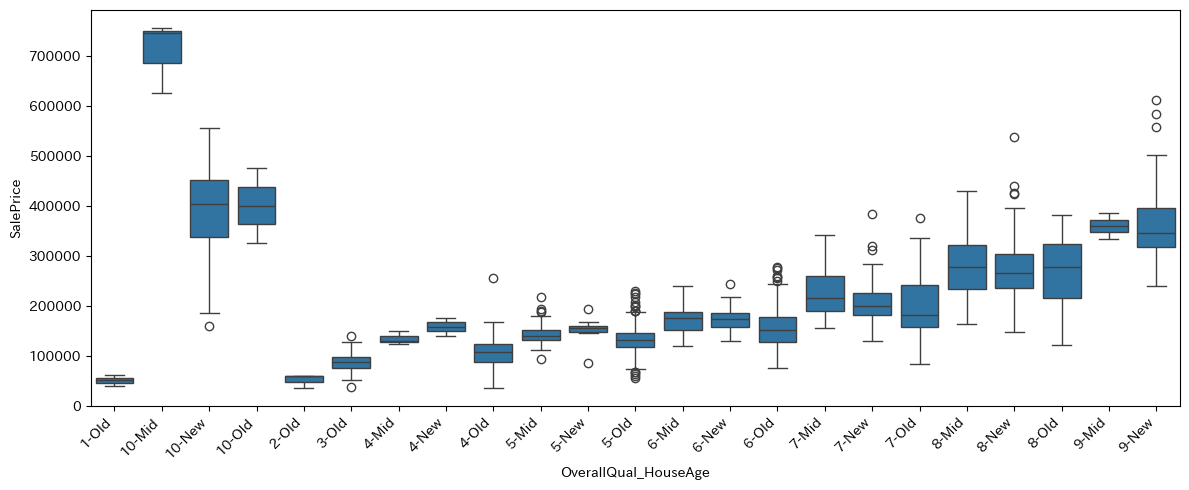

In [18]:
train_df = train_df.with_columns(
    pl.when((pl.col("YrSold") - pl.col("YearBuilt")) <= 10)
    .then(pl.lit("New"))
    .when((pl.col("YrSold") - pl.col("YearBuilt")) <= 30)
    .then(pl.lit("Mid"))
    .otherwise(pl.lit("Old"))
    .alias("HouseAgeCategory")
).with_columns(
    (pl.col("OverallQual").cast(pl.Utf8) + pl.lit("-") + pl.col("HouseAgeCategory")).alias("OverallQual_HouseAge")
)


fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(
    data=train_df,
    x="OverallQual_HouseAge",
    y=cfg.target,
    ax=ax,
    order=sorted(train_df["OverallQual_HouseAge"].unique()),
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


実際の特徴量加工の場合

- このように一つひとつの組み合わせを可視化して有効そうなものだけ作成するということが変数が多いと難しくなる
- そのため全組み合わせに対して新たな組み合わせ特徴量を作成するというやり方もある
  - カテゴリカル変数がn個あった場合nC2個の組み合わせ特徴量が作成できる
  - 膨大な数になるので注意が必要
  - 下の例だと84個のカラムが1119個になった



In [19]:
# 組み合わせ特徴量の作成例
from itertools import combinations


def create_categorical_interactions(df: pl.DataFrame, cat_cols: list[str]) -> pl.DataFrame:
    new_expressions = []
    for col1, col2 in combinations(cat_cols, 2):
        new_col_name = f"{col1}_{col2}"
        expression = (pl.col(col1).cast(pl.Utf8) + pl.lit("_") + pl.col(col2).cast(pl.Utf8)).alias(new_col_name)
        new_expressions.append(expression)

    return df.with_columns(new_expressions)


print(len(train_df.columns))
train_df = create_categorical_interactions(train_df, categorical_columns)
print(len(train_df.columns))


84
1119
